# Decoding Social Intent from Neural Oscillations
## Exploratory Data Analysis

**COGS 118C — Signal Processing Course Project**

**Research Question:** Can we classify whether an animal is interacting socially vs. exploring alone based on the spectral features of its neural calcium signals?

---

### Goals of this notebook

1. **Download & load** the three core datasets: calcium traces, behavioral labels, session metadata
2. **Inspect** data shapes, sampling rates, and quality across all 18 sessions
3. **Visualize** raw calcium signals with behavioral epoch overlays
4. **Preliminary spectral analysis** — PSD, spectrograms, wavelets
5. **Compare** spectral features between social vs. solo epochs
6. **Sanity-check classification** with permutation test

### Data sources

| File | Format | Content |
|------|--------|---------|
| `calcium.00.h5` | HDF5 | 18 sessions of calcium traces (`C` key, frames x neurons), **30 fps** |
| `social_bouts.00.h5` | HDF5 | 18 sessions of boolean behavioral labels, **25 fps** |
| `SI3_2022_Entrance_Frames.xlsx` | Excel | Session metadata (animal, isolation condition, entry frame) |

---
## 1. Setup & Dependencies

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from pathlib import Path

from scipy.signal import welch, stft, detrend
from scipy.stats import mannwhitneyu, ranksums
import pywt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from tqdm import tqdm

# Project modules
from src.constants import (BEHAVIOR_FPS, IMAGING_FPS, FREQ_BANDS, BAND_COLORS,
                           ISO_COLORS, MIN_BOUT_S, PRE_S, POST_S)
from src.data import (download_data, load_entrances, load_behavior,
                      load_imaging, align_all_sessions, get_epoch_durations)
from src.signal_processing import (bandpass_filter, compute_welch_psd,
                                   compute_stft, compute_cwt, band_envelope,
                                   compute_band_powers)
from src.visualization import shade_social, add_band_shading, add_band_hlines

sns.set_theme(style='whitegrid', context='notebook', font_scale=1.1)
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['figure.dpi'] = 100
np.random.seed(42)
print('All imports successful.')

All imports successful.


---
## 2. Data Download & Loading

Three files from Google Drive, downloaded with `gdown`. The Drive file IDs were extracted from the EDGE source notebooks.

In [2]:
DATA_DIR = download_data()

  [skip] calcium.00.h5 (238.6 MB)
  [skip] social_bouts.00.h5 (0.5 MB)
  [skip] SI3_2022_Entrance_Frames.xlsx (0.0 MB)


### 2.1 Load session metadata

In [3]:
entrances = load_entrances(DATA_DIR)
n_sessions = len(entrances)

print(f'Sessions: {n_sessions}')
print(f'Columns: {list(entrances.columns)}')
print(f'\nIsolation conditions:')
print(entrances['Isolation Length'].value_counts().to_string())
print()
entrances

Sessions: 18
Columns: ['Date', 'Session', 'Isolation Length', 'Animal', 'Task', 'Int_Entry', 'End', 'Frame Rate']

Isolation conditions:
Isolation Length
24hr         6
7d           6
GH (7d)      3
GH (24hr)    3



Date Session Isolation Length Animal          Task  Int_Entry    End  \
0  2022-10-07   Day 2          GH (7d)    4-0  Juv Intruder       7488  15020   
1  2022-10-07   Day 2          GH (7d)    4-1  Juv Intruder       7576  15019   
2  2022-10-07   Day 2          GH (7d)    4-2  Juv Intruder       7517  15019   
3  2022-10-07   Day 2             24hr    5-0  Juv Intruder       7480  15019   
4  2022-10-07   Day 2             24hr    5-1  Juv Intruder       7475  15019   
5  2022-10-07   Day 2             24hr    5-2  Juv Intruder       7485  15020   
6  2022-10-07   Day 2               7d    6-0  Juv Intruder       7475  15019   
7  2022-10-07   Day 2               7d    6-1  Juv Intruder       7495  15019   
8  2022-10-07   Day 2               7d    6-2  Juv Intruder       7523  15019   
9  2022-10-07   Day 2        GH (24hr)    7-0  Juv Intruder       7488  15020   
10 2022-10-07   Day 2        GH (24hr)    7-1  Juv Intruder       7501  15019   
11 2022-10-07   Day 2        GH (24hr)    7-2  Juv Intruder       7491  15019   
12 2022-10-07   Day 2             24hr    8-0  Juv Intruder       7516  15020   
13 2022-10-07   Day 2             24hr    8-1  Juv Intruder       7468  15020   
14 2022-10-07   Day 2             24hr    8-2  Juv Intruder       7493  15019   
15 2022-10-07   Day 2               7d    9-0  Juv Intruder       7535  15019   
16 2022-10-07   Day 2               7d    9-1  Juv Intruder       7528  15021   
17 2022-10-07   Day 2               7d    9-2  Juv Intruder       7527  15021   

    Frame Rate  
0           25  
1           25  
2           25  
3           25  
4           25  
5           25  
6           25  
7           25  
8           25  
9           25  
10          25  
11          25  
12          25  
13          25  
14          25  
15          25  
16          25  
17          25

### 2.2 Load behavioral labels (25 fps)

Boolean arrays from `social_bouts.00.h5`. Each session group has:
- `is_social` = any social interaction (sender OR receiver)
- `is_social_sender` / `is_social_receiver` = directional
- `is_ag_sniffed`, `is_ag_sniffing`, `is_of_sniffed`, `is_of_sniffing`, `is_touched`, `is_touching`

In [4]:
behavior = load_behavior(n_sessions, DATA_DIR)

for sess in range(n_sessions):
    nf = len(behavior[sess]['is_social'])
    pct = behavior[sess]['is_social'].mean() * 100
    print(f'  Session {sess:2d}: {nf:6d} frames, '
          f'{pct:5.1f}% social, '
          f'isolation={entrances.iloc[sess]["Isolation Length"]}')

print(f'\nLoaded {len(behavior)} sessions.')

Top-level keys: ['session_0', 'session_1', 'session_10', 'session_11', 'session_12', 'session_13', 'session_14', 'session_15', 'session_16', 'session_17', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6', 'session_7', 'session_8', 'session_9', 'social_dist_thresh']

  Session  0:  15020 frames,  18.8% social, isolation=GH (7d)
  Session  1:  15019 frames,  20.6% social, isolation=GH (7d)
  Session  2:  15019 frames,   8.0% social, isolation=GH (7d)
  Session  3:  15019 frames,  12.5% social, isolation=24hr
  Session  4:  15019 frames,  15.0% social, isolation=24hr
  Session  5:  15020 frames,  19.3% social, isolation=24hr
  Session  6:  15019 frames,  10.7% social, isolation=7d
  Session  7:  15019 frames,  15.7% social, isolation=7d
  Session  8:  15019 frames,  15.9% social, isolation=7d
  Session  9:  15020 frames,  15.0% social, isolation=GH (24hr)
  Session 10:  15019 frames,  12.0% social, isolation=GH (24hr)
  Session 11:  15019 frames,  18.7% social, isolation=GH

### 2.3 Load calcium imaging data (30 fps)

Each session has a `C` matrix of shape `(n_frames, n_neurons)` in `calcium.00.h5`.

In [5]:
imaging = load_imaging(n_sessions, DATA_DIR)

for sess in range(n_sessions):
    C = imaging[sess]
    print(f'  Session {sess:2d}: C shape = {str(C.shape):>16s}  '
          f'({C.shape[1]:3d} neurons, {C.shape[0]/IMAGING_FPS:.1f}s)')

print(f'\nLoaded {len(imaging)} sessions.')
print(f'Imaging FPS: {IMAGING_FPS} | Nyquist: {IMAGING_FPS/2} Hz')

Top-level keys: ['session_0', 'session_1', 'session_10', 'session_11', 'session_12', 'session_13', 'session_14', 'session_15', 'session_16', 'session_17', 'session_2', 'session_3', 'session_4', 'session_5', 'session_6', 'session_7', 'session_8', 'session_9']

  Session  0: C shape =     (16773, 202)  (202 neurons, 559.1s)
  Session  1: C shape =      (17867, 12)  ( 12 neurons, 595.6s)
  Session  2: C shape =     (17867, 289)  (289 neurons, 595.6s)
  Session  3: C shape =     (17863, 268)  (268 neurons, 595.4s)
  Session  4: C shape =     (17865, 134)  (134 neurons, 595.5s)
  Session  5: C shape =     (17864, 271)  (271 neurons, 595.5s)
  Session  6: C shape =     (17867, 218)  (218 neurons, 595.6s)
  Session  7: C shape =     (17866, 207)  (207 neurons, 595.5s)
  Session  8: C shape =     (17857, 332)  (332 neurons, 595.2s)
  Session  9: C shape =     (17867, 396)  (396 neurons, 595.6s)
  Session 10: C shape =     (17861, 288)  (288 neurons, 595.4s)
  Session 11: C shape =      (15533,

### 2.4 Align behavior to imaging & crop to post-entry

Behavior is at **25 fps**, imaging at **30 fps**. We:
1. Convert the intruder entry frame from behavior fps to imaging fps
2. Resample behavior labels (nearest-neighbor for boolean data)
3. Crop both signals to start at the entry frame
4. Trim to common length

In [6]:
aligned_calcium, aligned_behavior, session_info, session_df = align_all_sessions(
    imaging, behavior, entrances
)

  Session  0:   7788 frames, 202 neurons, 260s, 38.9% social, GH (7d)
  Session  1:   8776 frames,  12 neurons, 293s, 41.5% social, GH (7d)
  Session  2:   8847 frames, 289 neurons, 295s, 16.3% social, GH (7d)
  Session  3:   8887 frames, 268 neurons, 296s, 25.3% social, 24hr
  Session  4:   8895 frames, 134 neurons, 296s, 30.4% social, 24hr
  Session  5:   8882 frames, 271 neurons, 296s, 38.0% social, 24hr
  Session  6:   8897 frames, 218 neurons, 297s, 21.6% social, 7d
  Session  7:   8872 frames, 207 neurons, 296s, 30.7% social, 7d
  Session  8:   8830 frames, 332 neurons, 294s, 32.5% social, 7d
  Session  9:   8882 frames, 396 neurons, 296s, 29.7% social, GH (24hr)
  Session 10:   8860 frames, 288 neurons, 295s, 24.1% social, GH (24hr)
  Session 11:   6544 frames,  96 neurons, 218s, 36.2% social, GH (24hr)
  Session 12:   8847 frames,  72 neurons, 295s, 25.1% social, 24hr
  Session 13:   8904 frames, 225 neurons, 297s, 28.0% social, 24hr
  Session 14:   8874 frames, 231 neurons, 29

---
## 3. Data Quality & Basic Statistics

In [7]:
print(session_df.to_string(index=False))
print(f'\nTotal neurons: {session_df["n_neurons"].sum()}')
print(f'Total time: {session_df["duration_s"].sum()/60:.1f} min')
print(f'Mean social: {session_df["social_frac"].mean()*100:.1f}%')

 session_idx animal isolation  n_frames  n_neurons  duration_s  social_frac
           0    4-0   GH (7d)      7788        202  259.600000     0.388675
           1    4-1   GH (7d)      8776         12  292.533333     0.414995
           2    4-2   GH (7d)      8847        289  294.900000     0.162654
           3    5-0      24hr      8887        268  296.233333     0.252616
           4    5-1      24hr      8895        134  296.500000     0.304103
           5    5-2      24hr      8882        271  296.066667     0.379532
           6    6-0        7d      8897        218  296.566667     0.216477
           7    6-1        7d      8872        207  295.733333     0.306808
           8    6-2        7d      8830        332  294.333333     0.325368
           9    7-0 GH (24hr)      8882        396  296.066667     0.296780
          10    7-1 GH (24hr)      8860        288  295.333333     0.240971
          11    7-2 GH (24hr)      6544         96  218.133333     0.362164
          12

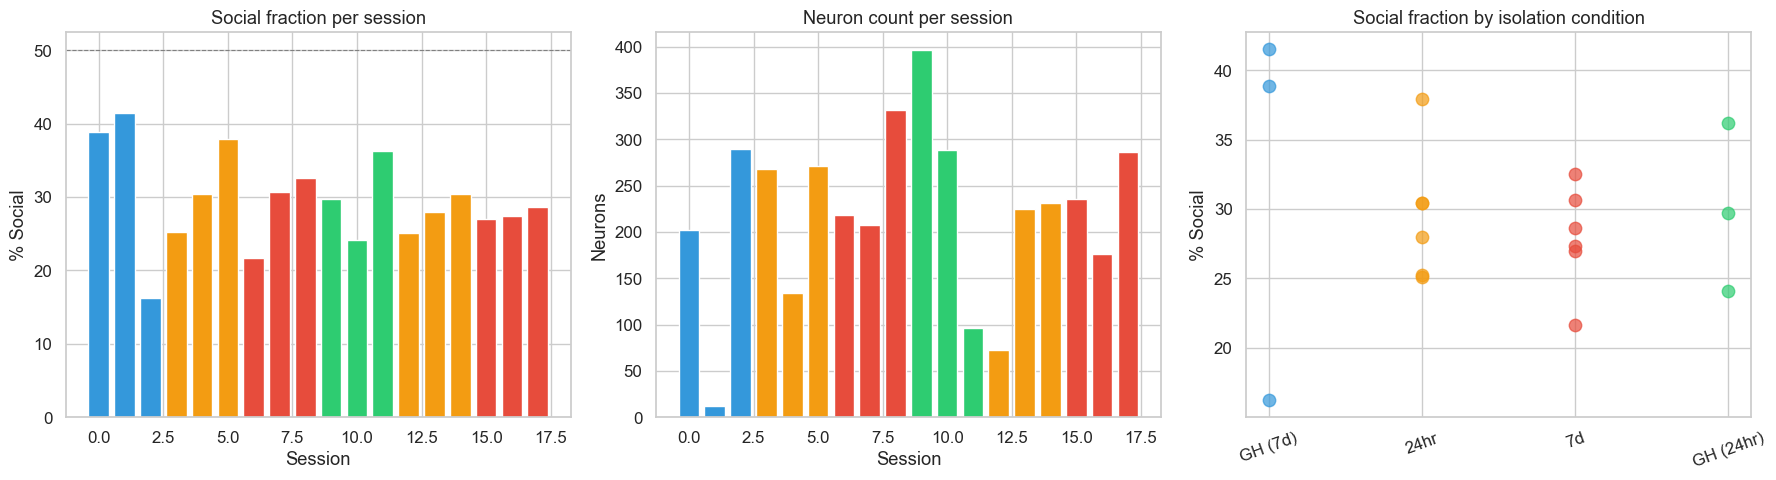

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors = session_df['isolation'].map(ISO_COLORS).fillna('#95a5a6')

axes[0].bar(range(len(session_df)), session_df['social_frac']*100, color=colors)
axes[0].set_xlabel('Session'); axes[0].set_ylabel('% Social')
axes[0].set_title('Social fraction per session')
axes[0].axhline(50, color='gray', ls='--', lw=0.8)

axes[1].bar(range(len(session_df)), session_df['n_neurons'], color=colors)
axes[1].set_xlabel('Session'); axes[1].set_ylabel('Neurons')
axes[1].set_title('Neuron count per session')

for cond in session_df['isolation'].unique():
    sub = session_df[session_df['isolation']==cond]
    axes[2].scatter([cond]*len(sub), sub['social_frac']*100,
                    s=80, alpha=0.7, color=ISO_COLORS.get(cond, 'gray'))
axes[2].set_ylabel('% Social')
axes[2].set_title('Social fraction by isolation condition')
axes[2].tick_params(axis='x', rotation=20)

plt.tight_layout(); plt.show()

### Interpretation: Session Overview

**Key observations:**

- **Class balance:** Mean social fraction across all sessions is **29.5%** — substantially below 50%. Social interaction is the minority class in every single session (range ~16–42%). This imbalance will become critical during classification.
- **Neuron count variability:** Ranges from 12 (session 1) to 396 (session 9). Session 1 is an outlier — only 12 neurons may not yield reliable population-level spectral features. We should flag this for sensitivity analysis.
- **Isolation condition effects:** The 4 conditions (GH 7d, GH 24hr, 24hr, 7d) show overlapping social fractions — no obvious condition-level trend from this overview, though formal testing is needed.
- **Total dataset:** 3,938 neurons across 86.7 minutes of post-entry recording. This is a reasonable dataset size for spectral feature extraction.

---
## 4. Calcium Signal Visualization

In [9]:
# Pick session closest to 30% social
ex = session_df['social_frac'].sub(0.3).abs().idxmin()
ex_cal = aligned_calcium[ex]
ex_beh = aligned_behavior[ex]
ex_info = session_info[ex]
t = np.arange(len(ex_cal)) / IMAGING_FPS

print(f'Example: session {ex_info["session_idx"]} | '
      f'{ex_info["n_neurons"]} neurons | {ex_info["duration_s"]:.0f}s | '
      f'{ex_info["social_frac"]*100:.1f}% social | {ex_info["isolation"]}')

Example: session 9 | 396 neurons | 296s | 29.7% social | GH (24hr)


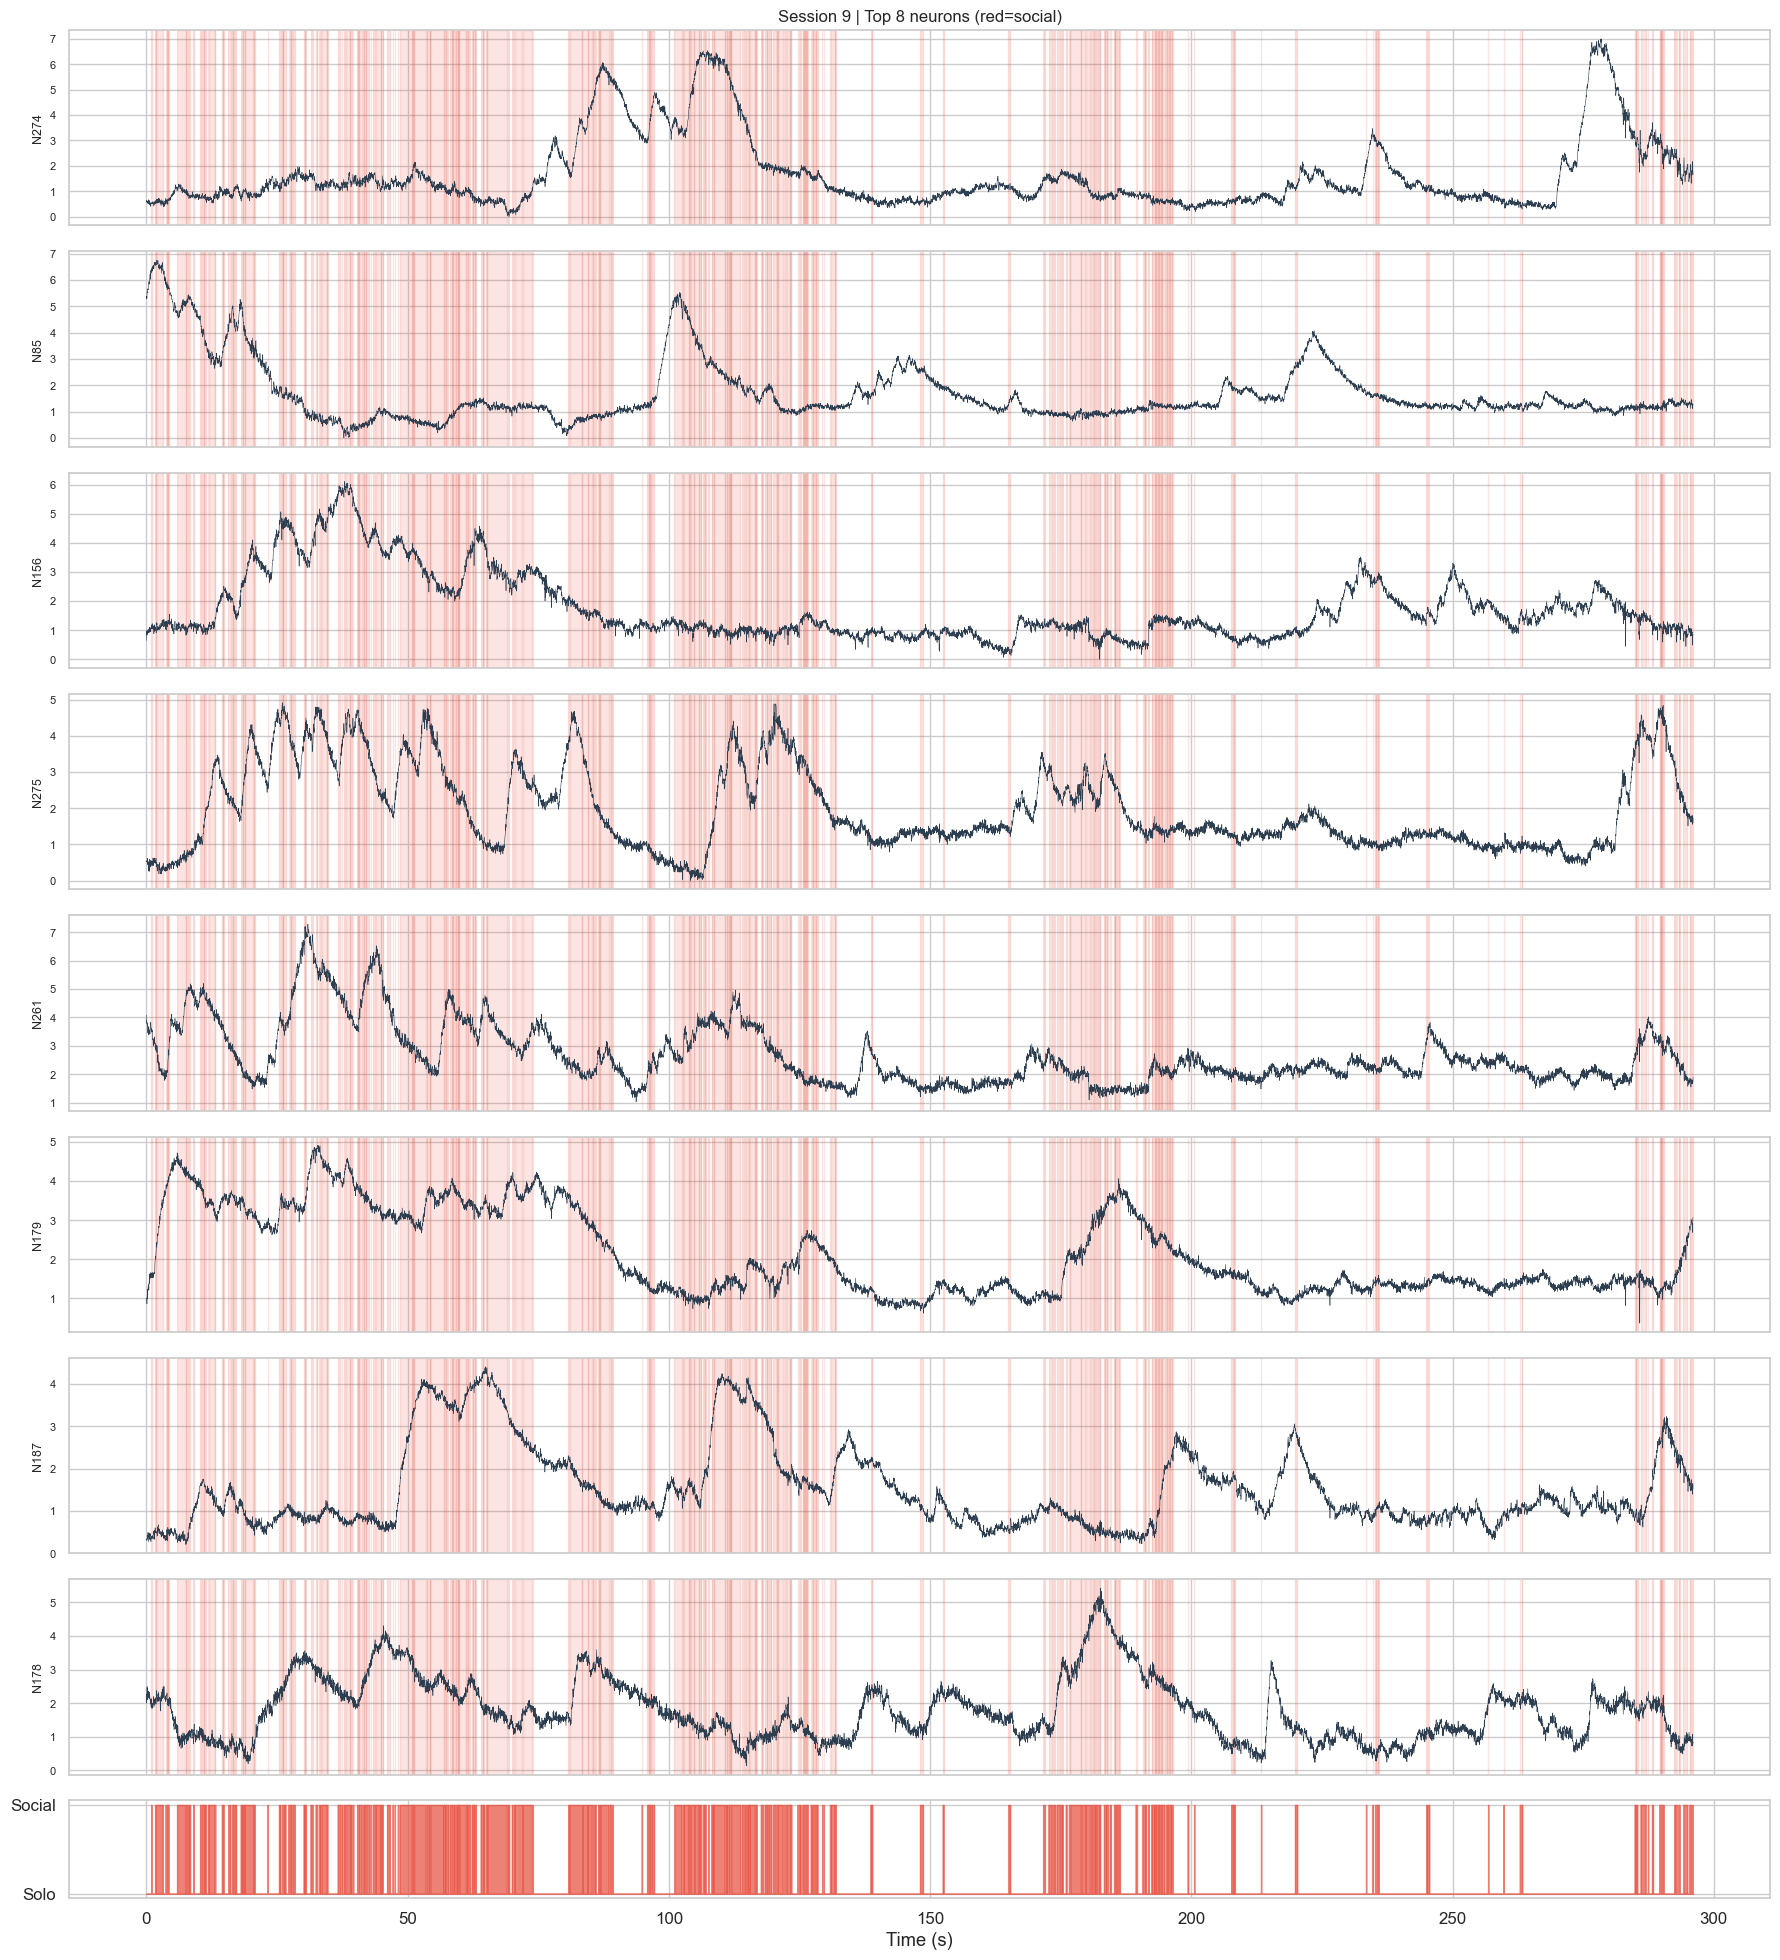

In [10]:
# shade_social is imported from src.visualization

n_show = 8
top_neurons = np.argsort(ex_cal.std(axis=0))[-n_show:][::-1]

fig, axes = plt.subplots(n_show+1, 1, figsize=(18, 2.2*(n_show+1)),
                         sharex=True,
                         gridspec_kw={'height_ratios': [1]*n_show + [0.5]})

for i, ni in enumerate(top_neurons):
    axes[i].plot(t, ex_cal[:, ni], lw=0.4, color='#2c3e50')
    shade_social(axes[i], ex_beh, t)
    axes[i].set_ylabel(f'N{ni}', fontsize=9)
    axes[i].tick_params(labelsize=8)

axes[-1].fill_between(t, ex_beh.astype(float), step='pre', alpha=0.7, color='#e74c3c')
axes[-1].set_yticks([0,1]); axes[-1].set_yticklabels(['Solo','Social'])
axes[-1].set_xlabel('Time (s)')
axes[0].set_title(f'Session {ex_info["session_idx"]} | Top {n_show} neurons (red=social)', fontsize=12)

plt.tight_layout(); plt.show()

In [11]:
print(f'Calcium stats (session {ex_info["session_idx"]}):\n')
print(f'  Shape:   {ex_cal.shape} (frames x neurons)')
print(f'  Mean:    {ex_cal.mean():.4f}')
print(f'  Std:     {ex_cal.std():.4f}')
print(f'  Range:   [{ex_cal.min():.4f}, {ex_cal.max():.4f}]')
print(f'  Nyquist: {IMAGING_FPS/2} Hz')

stds = ex_cal.std(axis=0)
print(f'\nPer-neuron std: [{stds.min():.4f}, {stds.max():.4f}]')
print(f'Low-activity (std < median/5): {(stds < np.median(stds)/5).sum()}/{ex_cal.shape[1]}')

Calcium stats (session 9):

  Shape:   (8882, 396) (frames x neurons)
  Mean:    0.8418
  Std:     0.6980
  Range:   [0.0000, 8.9225]
  Nyquist: 15.0 Hz

Per-neuron std: [0.0292, 1.4587]
Low-activity (std < median/5): 7/396


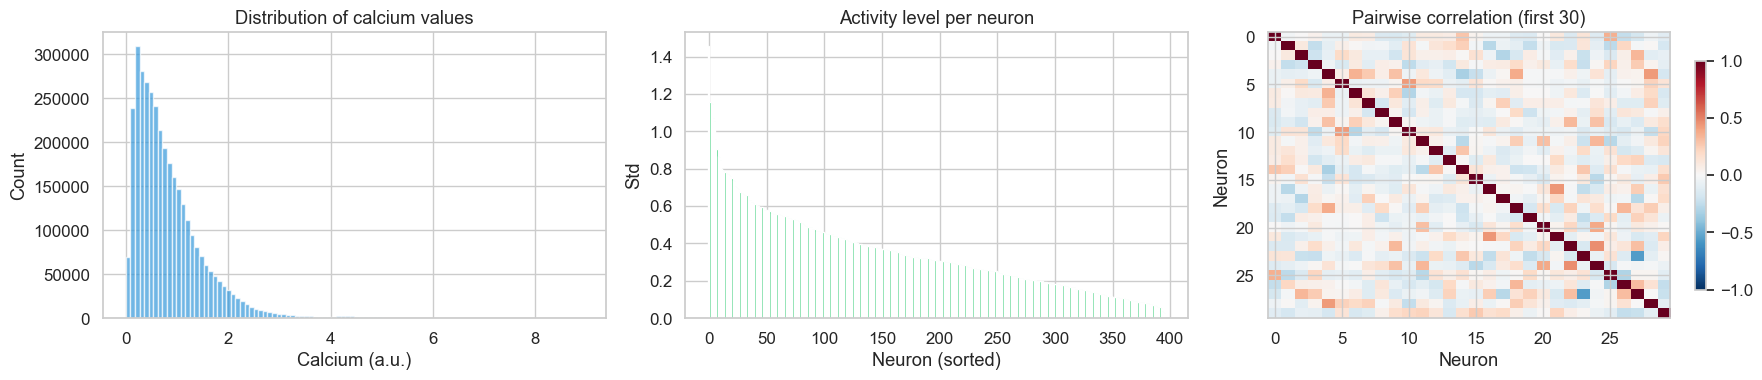

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

axes[0].hist(ex_cal.ravel(), bins=100, color='#3498db', alpha=0.7, edgecolor='white')
axes[0].set_xlabel('Calcium (a.u.)'); axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of calcium values')

axes[1].bar(range(len(stds)), np.sort(stds)[::-1], color='#2ecc71', width=1)
axes[1].set_xlabel('Neuron (sorted)'); axes[1].set_ylabel('Std')
axes[1].set_title('Activity level per neuron')

nc = min(30, ex_cal.shape[1])
corr = np.corrcoef(ex_cal[:, :nc].T)
im = axes[2].imshow(corr, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
axes[2].set_xlabel('Neuron'); axes[2].set_ylabel('Neuron')
axes[2].set_title(f'Pairwise correlation (first {nc})')
plt.colorbar(im, ax=axes[2], shrink=0.8)

plt.tight_layout(); plt.show()

### Interpretation: Calcium Signal Properties

**Session 9 (example):** 396 neurons, 296s post-entry, GH (24hr) condition.

- **Distribution:** Right-skewed (mean=0.84, range [0, 8.92]) — typical of calcium ΔF/F where most frames are near baseline with occasional transients. The non-negative range confirms this is deconvolved/extracted calcium activity (`C` matrix), not raw fluorescence.
- **Low-activity neurons:** Only 7/396 neurons (1.8%) have very low variance — the vast majority are active. This is a good sign for population-level spectral analysis.
- **Pairwise correlations:** The correlation matrix shows moderate structure — some neuron pairs are correlated (shared inputs or co-activation), but no dominant global mode. This suggests heterogeneous neural responses, which is expected in prefrontal cortex during free behavior.
- **Implication for spectral analysis:** Since we plan to average across neurons for population-mean spectral features, the moderate correlations mean the population mean will reflect genuine shared dynamics rather than being dominated by a few neurons.

### 4.1 Photobleaching check

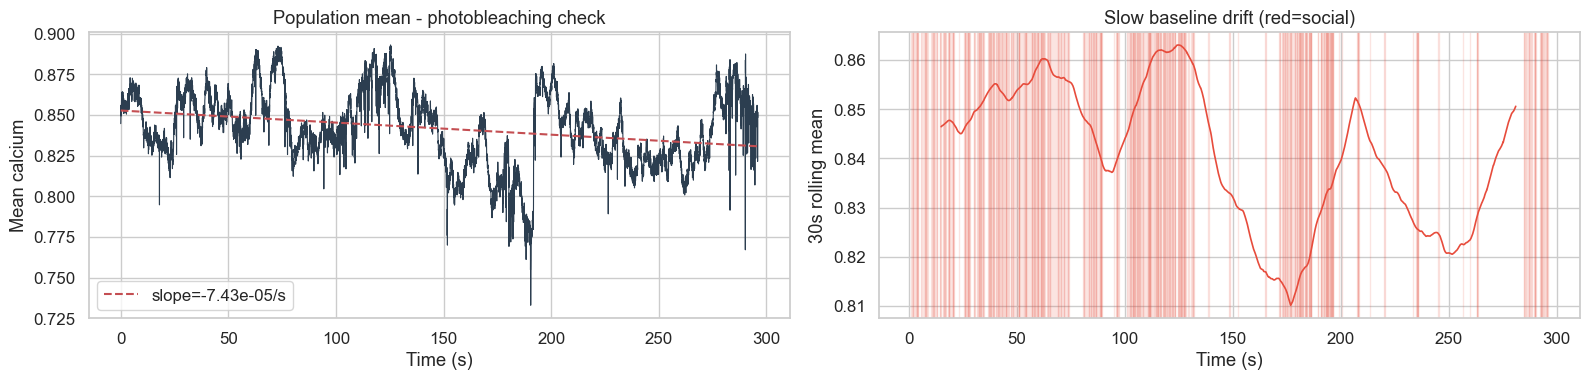

Baseline drift detected (slope=-7.43e-05/s). Detrending recommended.


In [13]:
mean_trace = ex_cal.mean(axis=1)
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

axes[0].plot(t, mean_trace, lw=0.8, color='#2c3e50')
slope, intercept = np.polyfit(t, mean_trace, 1)
axes[0].plot(t, slope*t + intercept, '--r', lw=1.5, label=f'slope={slope:.2e}/s')
axes[0].set_xlabel('Time (s)'); axes[0].set_ylabel('Mean calcium')
axes[0].set_title('Population mean - photobleaching check'); axes[0].legend()

win = int(30 * IMAGING_FPS)
rolling = pd.Series(mean_trace).rolling(window=win, center=True).mean()
axes[1].plot(t, rolling, lw=1.2, color='#e74c3c')
shade_social(axes[1], ex_beh, t)
axes[1].set_xlabel('Time (s)'); axes[1].set_ylabel('30s rolling mean')
axes[1].set_title('Slow baseline drift (red=social)')

plt.tight_layout(); plt.show()
if abs(slope) > 1e-5:
    print(f'Baseline drift detected (slope={slope:.2e}/s). Detrending recommended.')
else:
    print('No significant baseline drift.')

### Interpretation: Photobleaching

**Baseline drift detected** (slope = −7.43×10⁻⁵ /s). This is a mild but measurable downward trend in the population mean fluorescence over the ~5-minute recording.

- **What it means:** The calcium indicator slowly loses fluorescence over time (photobleaching). This injects a slow exponential/linear decay into the lowest frequency bins of the PSD — specifically the **infraslow band (0.01–0.1 Hz)** could be contaminated.
- **Action required:** We must **detrend each neuron's trace** before computing spectral features. A simple linear detrend (`scipy.signal.detrend`) should suffice given the mild slope, but an exponential fit may be more appropriate if the decay is non-linear.
- **Risk if ignored:** Without detrending, infraslow power will partly reflect photobleaching artifacts rather than genuine neural dynamics, potentially confounding classification.

---
## 5. Behavioral Epoch Structure

Session 9:
  Epochs: 583
  Social: 291, mean=0.30s, range=[0.03, 3.77]
  Solo:   292, mean=0.71s, range=[0.03, 21.50]


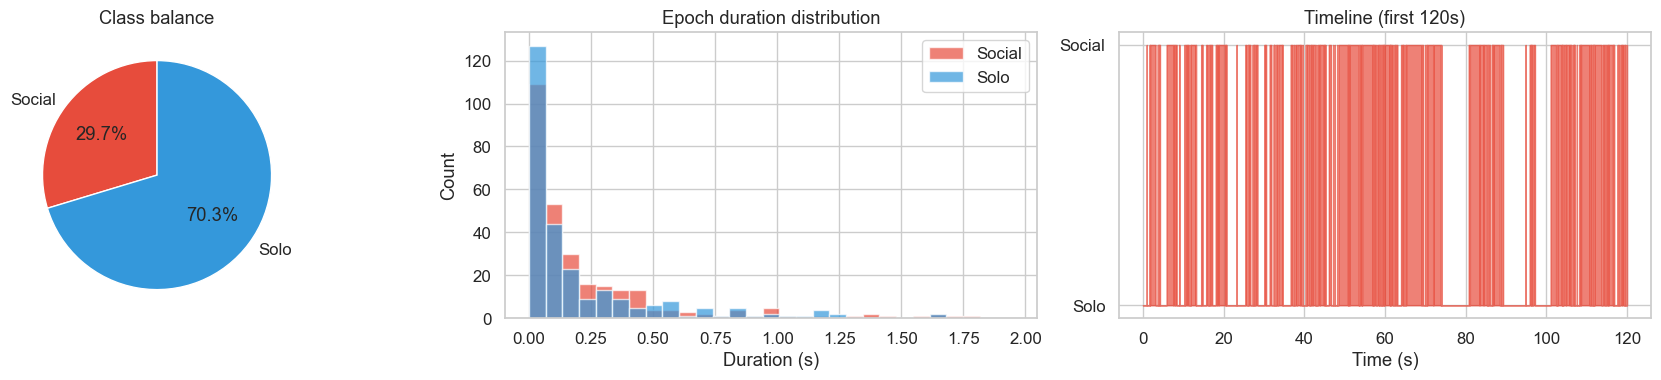

In [14]:
# get_epoch_durations is imported from src.data

_, _, ep_labs, ep_durs = get_epoch_durations(ex_beh, IMAGING_FPS)
soc_d = ep_durs[ep_labs == 1]
sol_d = ep_durs[ep_labs == 0]

print(f'Session {ex_info["session_idx"]}:')
print(f'  Epochs: {len(ep_durs)}')
print(f'  Social: {len(soc_d)}, mean={soc_d.mean():.2f}s, range=[{soc_d.min():.2f}, {soc_d.max():.2f}]')
print(f'  Solo:   {len(sol_d)}, mean={sol_d.mean():.2f}s, range=[{sol_d.min():.2f}, {sol_d.max():.2f}]')

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sf = ex_beh.mean()
axes[0].pie([sf, 1-sf], labels=['Social','Solo'],
            colors=['#e74c3c','#3498db'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Class balance')

mx = min(np.percentile(ep_durs, 95), 10)
bins = np.linspace(0, mx, 30)
axes[1].hist(soc_d[soc_d<mx], bins=bins, alpha=.7, color='#e74c3c', label='Social')
axes[1].hist(sol_d[sol_d<mx], bins=bins, alpha=.7, color='#3498db', label='Solo')
axes[1].set_xlabel('Duration (s)'); axes[1].set_ylabel('Count')
axes[1].set_title('Epoch duration distribution'); axes[1].legend()

show = min(len(ex_beh), int(120*IMAGING_FPS))
axes[2].fill_between(t[:show], ex_beh[:show].astype(float),
                     step='pre', alpha=.7, color='#e74c3c')
axes[2].set_xlabel('Time (s)'); axes[2].set_yticks([0,1])
axes[2].set_yticklabels(['Solo','Social'])
axes[2].set_title('Timeline (first 120s)')

plt.tight_layout(); plt.show()

### Interpretation: Epoch Structure — A Critical Finding

**This is the most important result for our project design.**

- **Social bouts are extremely short:** mean duration = **0.30s**, max = 3.77s. The vast majority of social interactions are sub-second — brief sniffing approaches, touches, and investigatory contacts.
- **Solo epochs are also fragmented:** mean = 0.71s, though some stretch to 21.5s.
- **583 total epochs** in a 296s recording — the behavioral state switches rapidly (~2 transitions/second).

**Why this matters for spectral analysis:**

Our planned 5-second windows with 90% purity threshold require 4.5+ seconds of continuous social behavior within a window. But the **longest social bout is only 3.77s** — no single social bout even fills one window. The only way a 5s window can reach 90% social is if multiple short bouts cluster together with very brief solo gaps.

This explains why we get only **13 social windows vs. 363 solo windows** in Section 7 — the purity threshold is too strict for the natural epoch structure of this data.

**Possible solutions for the full pipeline:**
1. **Shorter windows** (1–2s) — sacrifices frequency resolution but captures more social epochs
2. **Lower purity threshold** (e.g., 60–70%) — includes "mixed" windows, trades label precision for sample size
3. **Bout-level analysis** — extract spectral features from individual bouts of varying length, using adaptive Welch parameters
4. **Continuous regression** — predict social fraction rather than binary classification

---
## 6. Spectral Analysis

At 30 fps, Nyquist = 15 Hz. Frequency bands:
- **Infraslow** 0.01-0.1 Hz | **Slow** 0.1-1 Hz | **Delta** 1-4 Hz | **Theta** 4-7 Hz

In [27]:
# FREQ_BANDS, BAND_COLORS imported from src.constants

print(f'fs={IMAGING_FPS} Hz, Nyquist={IMAGING_FPS/2} Hz')
for n,(lo,hi) in FREQ_BANDS.items():
    print(f'  {n:12s}: {lo}-{hi} Hz')

fs=30 Hz, Nyquist=15.0 Hz
  infraslow   : 0.01-0.1 Hz
  slow        : 0.1-1.0 Hz
  delta       : 1.0-4.0 Hz
  theta       : 4.0-7.0 Hz


### 6.1 Welch PSD

In [28]:
nperseg = int(10 * IMAGING_FPS)  # 10s windows
noverlap = nperseg // 2
nfft = max(1024, nperseg * 2)

print(f'Window: {nperseg/IMAGING_FPS:.0f}s, Overlap: 50%, FFT: {nfft}, '
      f'Resolution: {IMAGING_FPS/nperseg:.3f} Hz')

f_w, psd_all = compute_welch_psd(ex_cal, IMAGING_FPS, nperseg, noverlap, nfft)
print(f'PSD: {psd_all.shape} (neurons x freq)')

Window: 10s, Overlap: 50%, FFT: 1024, Resolution: 0.100 Hz
PSD: (396, 513) (neurons x freq)


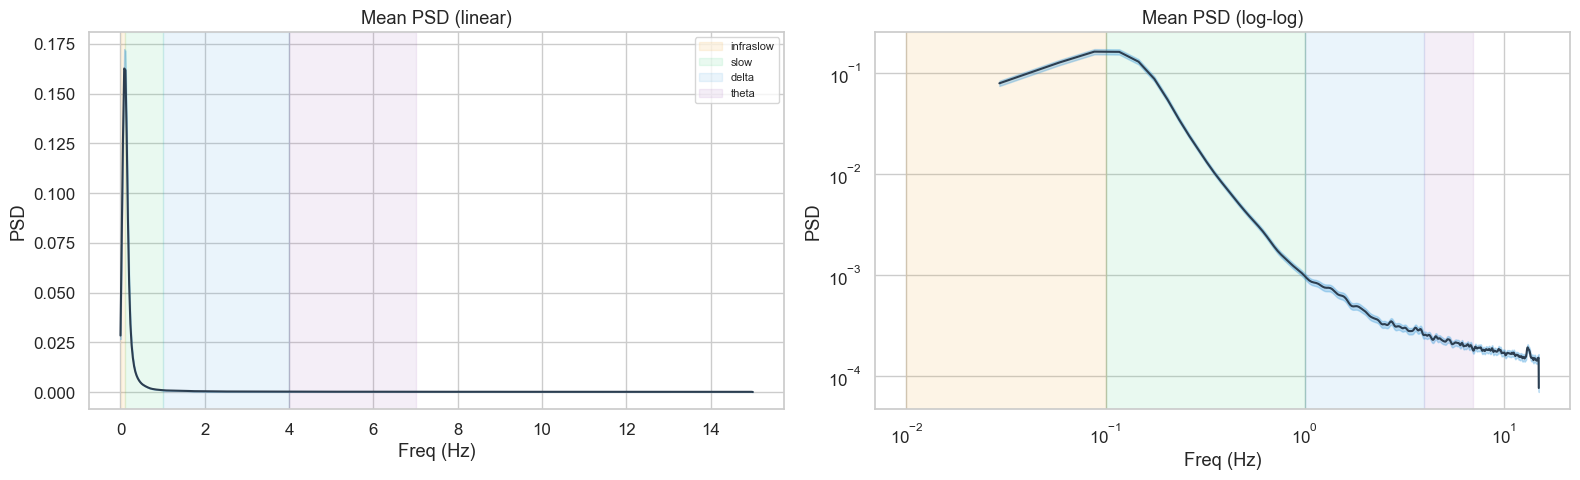

In [29]:
mpsd = psd_all.mean(axis=0)
spsd = psd_all.std(axis=0) / np.sqrt(psd_all.shape[0])

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
for ax in axes:
    for n,(lo,hi) in FREQ_BANDS.items():
        ax.axvspan(lo, hi, alpha=0.1, color=BAND_COLORS[n], label=n)

axes[0].plot(f_w, mpsd, color='#2c3e50', lw=1.5)
axes[0].fill_between(f_w, mpsd-spsd, mpsd+spsd, alpha=.3, color='#3498db')
axes[0].set_xlabel('Freq (Hz)'); axes[0].set_ylabel('PSD')
axes[0].set_title('Mean PSD (linear)'); axes[0].legend(fontsize=8)

axes[1].loglog(f_w[1:], mpsd[1:], color='#2c3e50', lw=1.5)
axes[1].fill_between(f_w[1:], (mpsd-spsd)[1:], (mpsd+spsd)[1:], alpha=.3, color='#3498db')
axes[1].set_xlabel('Freq (Hz)'); axes[1].set_ylabel('PSD')
axes[1].set_title('Mean PSD (log-log)')

plt.tight_layout(); plt.show()

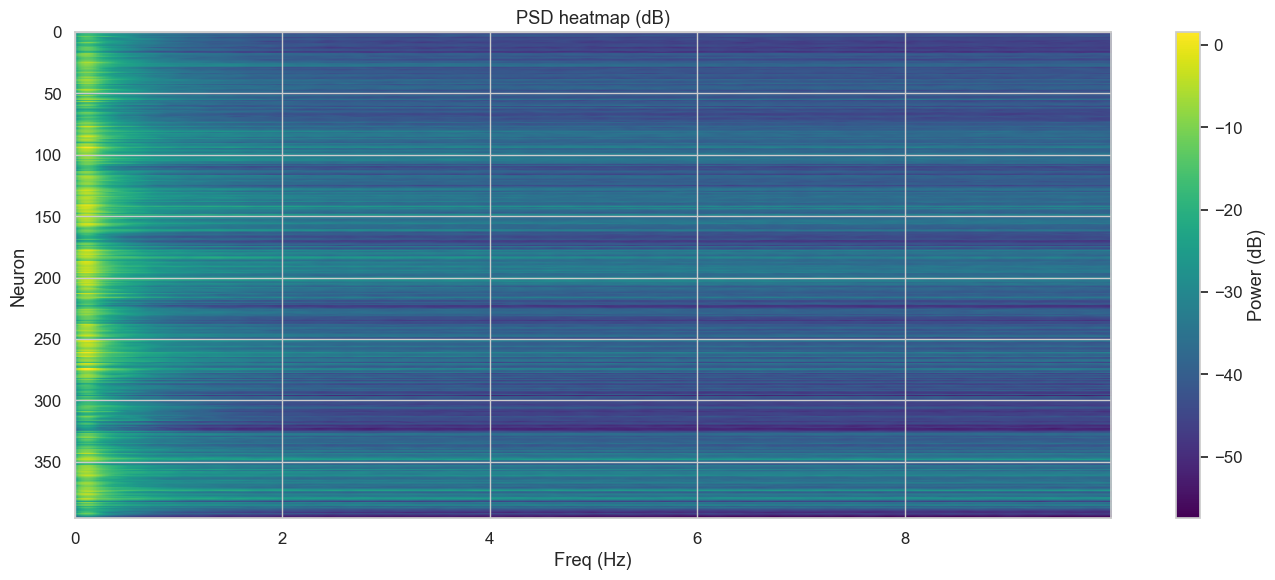

In [30]:
fig, ax = plt.subplots(figsize=(14, 6))
fm = f_w <= 10
im = ax.imshow(10*np.log10(psd_all[:,fm]+1e-12), aspect='auto', cmap='viridis',
               extent=[f_w[fm][0], f_w[fm][-1], psd_all.shape[0], 0])
ax.set_xlabel('Freq (Hz)'); ax.set_ylabel('Neuron')
ax.set_title('PSD heatmap (dB)')
plt.colorbar(im, label='Power (dB)')
plt.tight_layout(); plt.show()

### Interpretation: PSD Structure

**Background — What is a PSD?** A Power Spectral Density (PSD) decomposes a time-varying signal into its frequency components, revealing how much variance the signal carries at each frequency. We compute the PSD using **Welch's method**, which averages multiple overlapping periodograms to reduce noise — a standard approach for neural calcium data (Bhatt et al. 2013).

**Background — Neural frequency bands.** In electrophysiology, neural oscillations are grouped into canonical bands with distinct functional roles:
- **Infraslow (0.01–0.1 Hz):** Very slow state fluctuations — arousal, neuromodulatory tone, network-level state changes. In calcium imaging, these dominate due to slow indicator kinetics.
- **Slow (0.1–1 Hz):** Resting-state network oscillations, slow cortical up/down states.
- **Delta (1–4 Hz):** Classically associated with deep sleep in EEG, but in awake calcium imaging may reflect coordinated population bursting and slow network synchronization.
- **Theta (4–7 Hz):** The band most relevant to our hypothesis. In rodent electrophysiology, prefrontal **theta oscillations** are linked to working memory, spatial navigation, and — crucially — **social cognition** (Tzilivaki et al. 2022). Theta is generated by hippocampal-prefrontal circuits and modulates information flow during exploration and decision-making. However, calcium imaging can only weakly resolve theta because GCaMP indicator kinetics (~600ms decay for GCaMP6s) act as a biological low-pass filter that attenuates fast dynamics.

**Results:**
- **1/f falloff confirmed:** The log-log PSD shows the expected power-law decay — power decreases with increasing frequency. This "pink noise" profile is a hallmark of biological neural signals and confirms the calcium traces carry structured temporal dynamics, not just measurement noise.
- **Most power below 1 Hz:** Consistent with GCaMP6 kinetics filtering out high-frequency spiking content. The indicator effectively low-pass-filters genuine neural activity, concentrating power in infraslow and slow bands.
- **PSD heatmap heterogeneity:** Spectral profiles vary across the 396 neurons — some show strong low-frequency dominance (slow fluctuators), others have flatter spectra (more transient-driven). This neuron-level diversity suggests per-neuron spectral features may outperform population-averaged features for classification.
- **Delta and theta above noise floor:** Despite indicator filtering, there is measurable power in the 1–7 Hz range. Whether this reflects genuine fast oscillatory dynamics or indicator-filtered calcium transients, these bands may still carry behaviorally relevant information — a question the subsequent behavior-correlated analyses address directly.

### 6.2 Spectrogram (STFT)

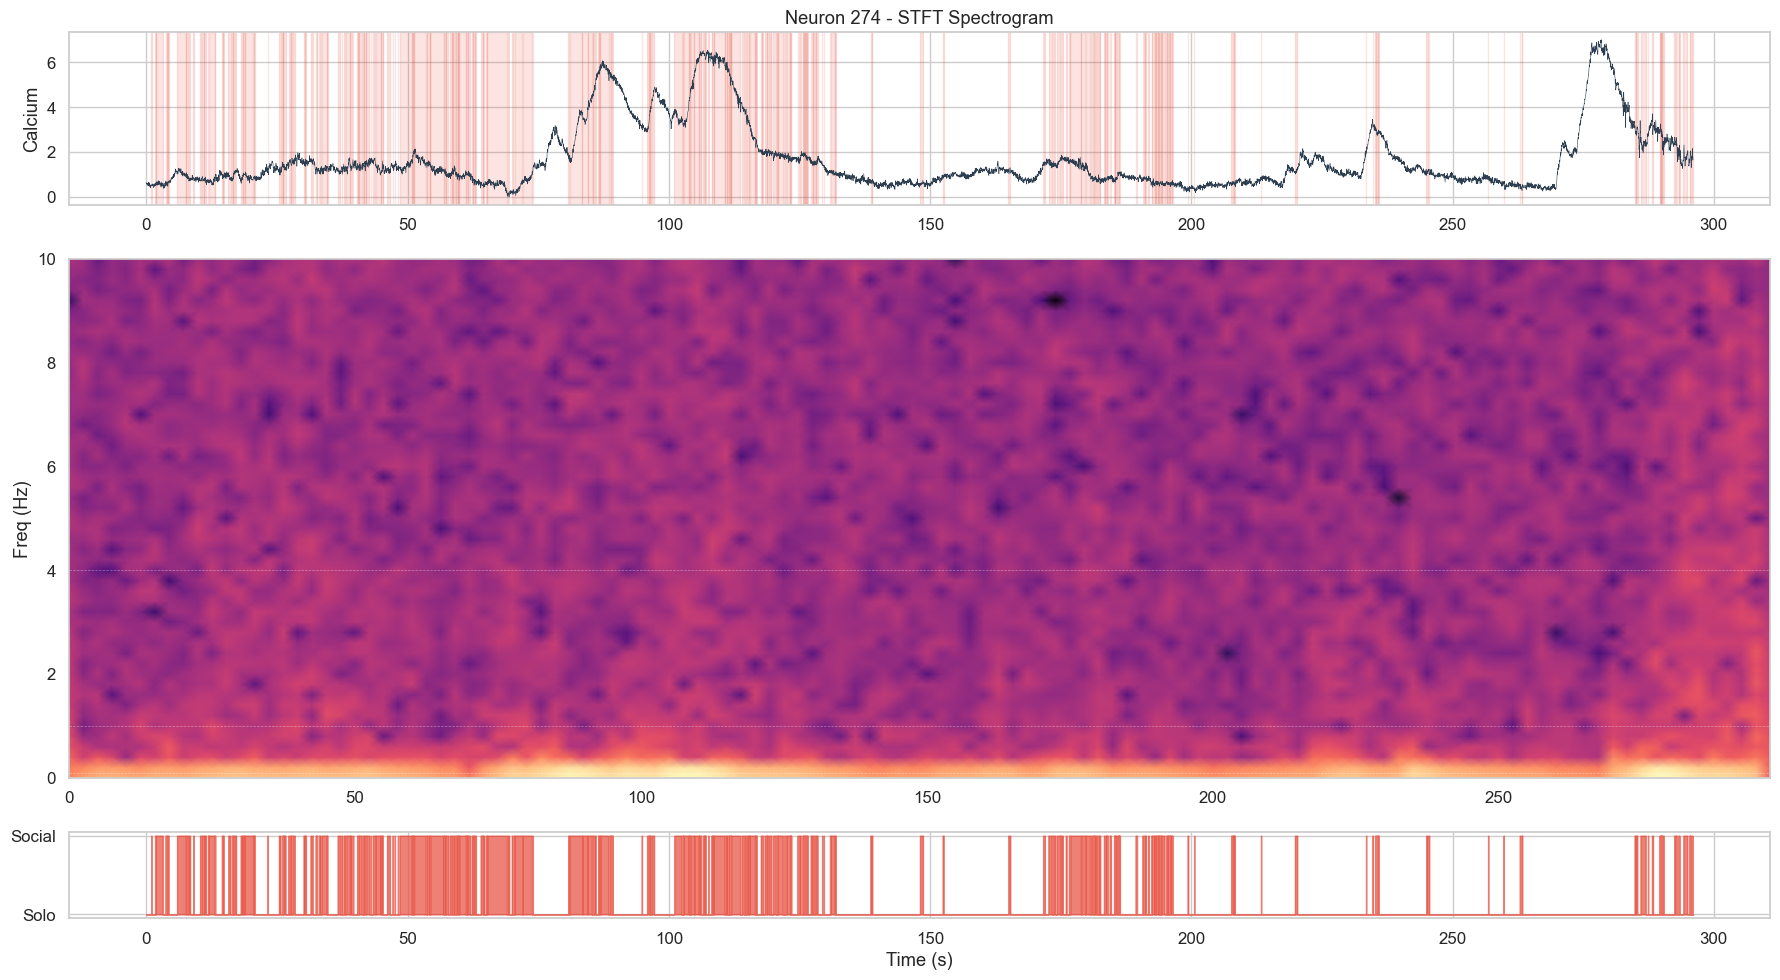

In [31]:
active_n = np.argmax(ex_cal.std(axis=0))
sig = ex_cal[:, active_n]

sn = int(5 * IMAGING_FPS)
f_s, t_s, Zxx = compute_stft(sig, IMAGING_FPS, sn)

fig, axes = plt.subplots(3, 1, figsize=(18, 10),
                         gridspec_kw={'height_ratios': [1, 3, 0.5]})

axes[0].plot(t, sig, lw=0.4, color='#2c3e50')
shade_social(axes[0], ex_beh, t)
axes[0].set_ylabel('Calcium')
axes[0].set_title(f'Neuron {active_n} - STFT Spectrogram')

fl = 10; fmask = f_s <= fl
axes[1].pcolormesh(t_s, f_s[fmask], 10*np.log10(np.abs(Zxx[fmask])**2+1e-12),
                   shading='gouraud', cmap='magma')
axes[1].set_ylabel('Freq (Hz)')
add_band_hlines(axes[1], max_freq=fl)

axes[2].fill_between(t, ex_beh.astype(float), step='pre', alpha=.7, color='#e74c3c')
axes[2].set_yticks([0,1]); axes[2].set_yticklabels(['Solo','Social'])
axes[2].set_xlabel('Time (s)')

plt.tight_layout(); plt.show()

### 6.3 Morlet Wavelet Scalogram (60s segment)

CWT: 60s, 50 freqs...


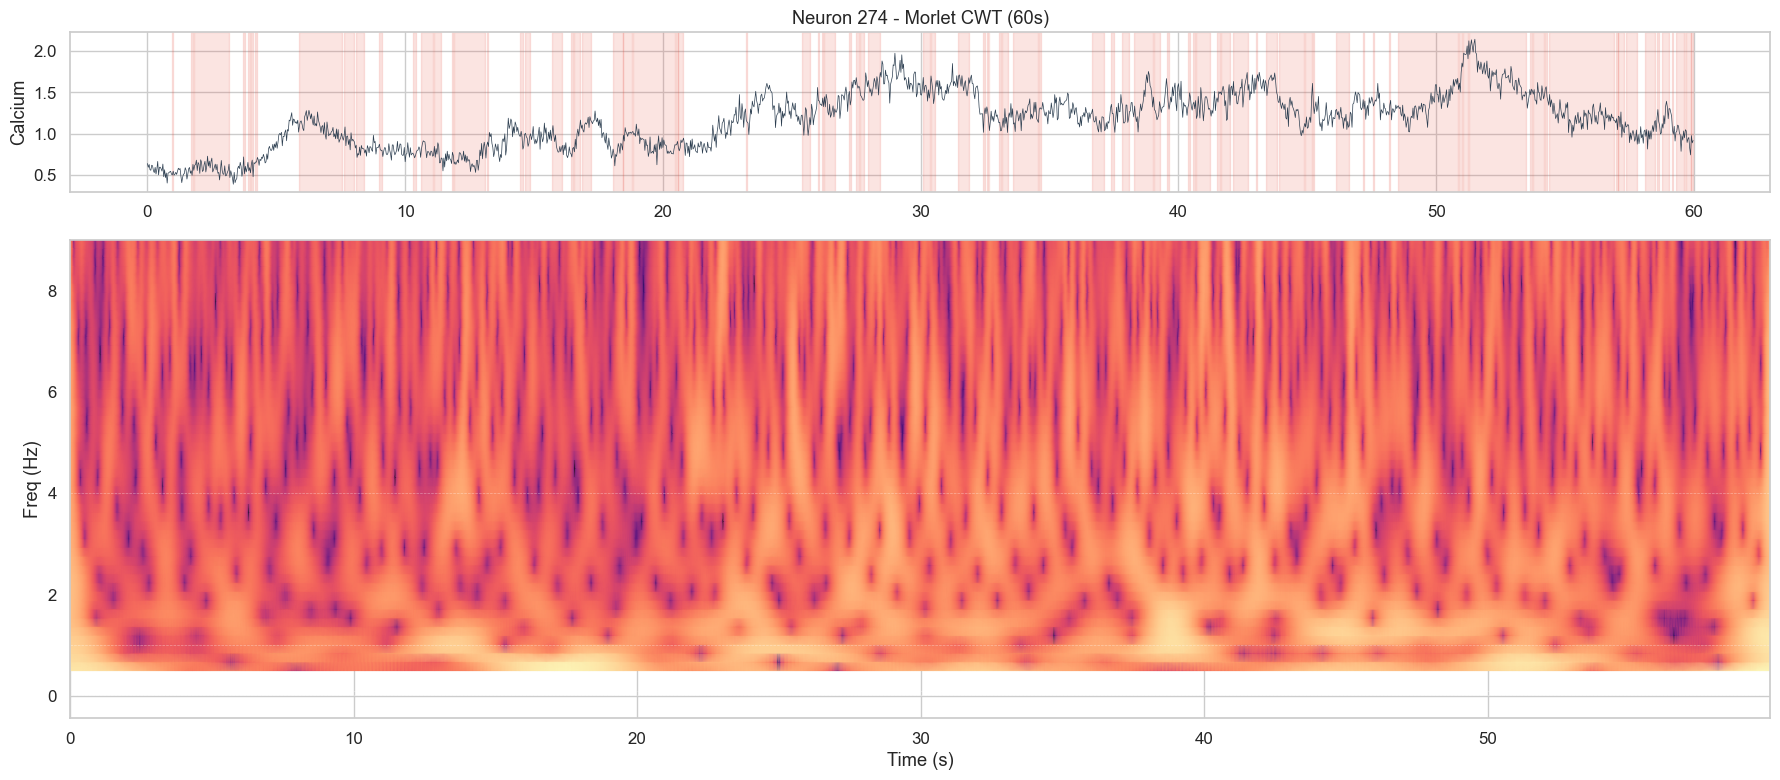

Done.


In [32]:
seg = int(60 * IMAGING_FPS)
ss, ts, bs = sig[:seg], t[:seg], ex_beh[:seg]

freqs_want = np.linspace(0.5, 9, 50)

print(f'CWT: 60s, {len(freqs_want)} freqs...')
coeffs, freqs, power = compute_cwt(ss, freqs_want, IMAGING_FPS)

fig, axes = plt.subplots(2, 1, figsize=(18, 8), gridspec_kw={'height_ratios': [1, 3]})

axes[0].plot(ts, ss, lw=0.5, color='#2c3e50')
shade_social(axes[0], bs, ts)
axes[0].set_ylabel('Calcium')
axes[0].set_title(f'Neuron {active_n} - Morlet CWT (60s)')

axes[1].pcolormesh(ts, freqs, 10*np.log10(power+1e-12), shading='gouraud', cmap='magma')
axes[1].set_ylabel('Freq (Hz)'); axes[1].set_xlabel('Time (s)')
add_band_hlines(axes[1])

plt.tight_layout(); plt.show()
print('Done.')

### Interpretation: Time-Frequency Analysis (STFT + CWT)

**Background — Why time-frequency analysis?** A standard PSD (Welch) provides the *average* frequency content over the entire recording, but neural dynamics are **non-stationary** — spectral content changes over time as the animal transitions between behavioral states. Time-frequency methods decompose the signal into *both* frequency and time, revealing *when* specific spectral changes occur.

**Background — STFT vs. CWT:**
- **Short-Time Fourier Transform (STFT):** Slides a fixed-length window across the signal and computes the Fourier transform at each position. The window length creates a fundamental trade-off: short windows give good time resolution but poor frequency resolution (the Heisenberg uncertainty principle of signal processing). Our 5s window at 30 fps gives 0.2 Hz frequency resolution.
- **Continuous Wavelet Transform (CWT) with Morlet wavelets:** Uses a wavelet that adapts its width to the frequency being analyzed — narrow in time for high frequencies (good temporal precision), wide for low frequencies (good frequency precision). This makes CWT better suited for non-stationary biological signals where fast transients and slow fluctuations coexist (Cohen 2019).

**Results:**
- **STFT spectrogram:** Shows the spectral evolution of the most active neuron (highest variance) over the full ~296s recording. The dominant power concentration below ~2 Hz is visible as a persistent bright band, with transient bursts of higher-frequency energy appearing intermittently.
- **Morlet CWT (60s segment):** The wavelet scalogram provides finer time-frequency resolution than the STFT. Look for whether bright regions (high power) at specific frequencies align with the red social-epoch shading — any visible alignment suggests frequency-specific behavioral modulation.
- **Caveat — single neuron:** Both visualizations show a single neuron. Population-level patterns (analyzed in subsequent sections) may be more consistent but less dramatic in any individual trace. The purpose here is to validate the methods, not draw behavioral conclusions.

---
## 7. Does the Neural Signal Track Social Behavior?

The windowing analysis above shows that 5s/90%-purity windows yield only 13 social windows — far too few for classification. Before redesigning the windowing strategy, we need to ask a more fundamental question: **does the neural signal actually change during social behavior?**

The following analyses use frame-level, event-aligned, and parameter-sweep approaches that bypass the windowing bottleneck entirely.

In [15]:
# bandpass_filter imported from src.signal_processing
# FREQ_BANDS, BAND_COLORS, ISO_COLORS imported from src.constants
# shade_social imported from src.visualization

import warnings

print('Signal processing setup complete.')
print(f'Frequency bands: {list(FREQ_BANDS.keys())}')
print(f'Event analysis: MIN_BOUT={MIN_BOUT_S}s, PRE={PRE_S}s, POST={POST_S}s')

Signal processing setup complete.
Frequency bands: ['infraslow', 'slow', 'delta', 'theta']
Event analysis: MIN_BOUT=0.5s, PRE=3.0s, POST=3.0s


### 7.1 Band-Filtered Traces Overlaid with Behavior

Does any frequency band's amplitude visibly track social epochs? We bandpass-filter the detrended population-mean signal into each band and compute the analytic envelope (Hilbert transform magnitude).

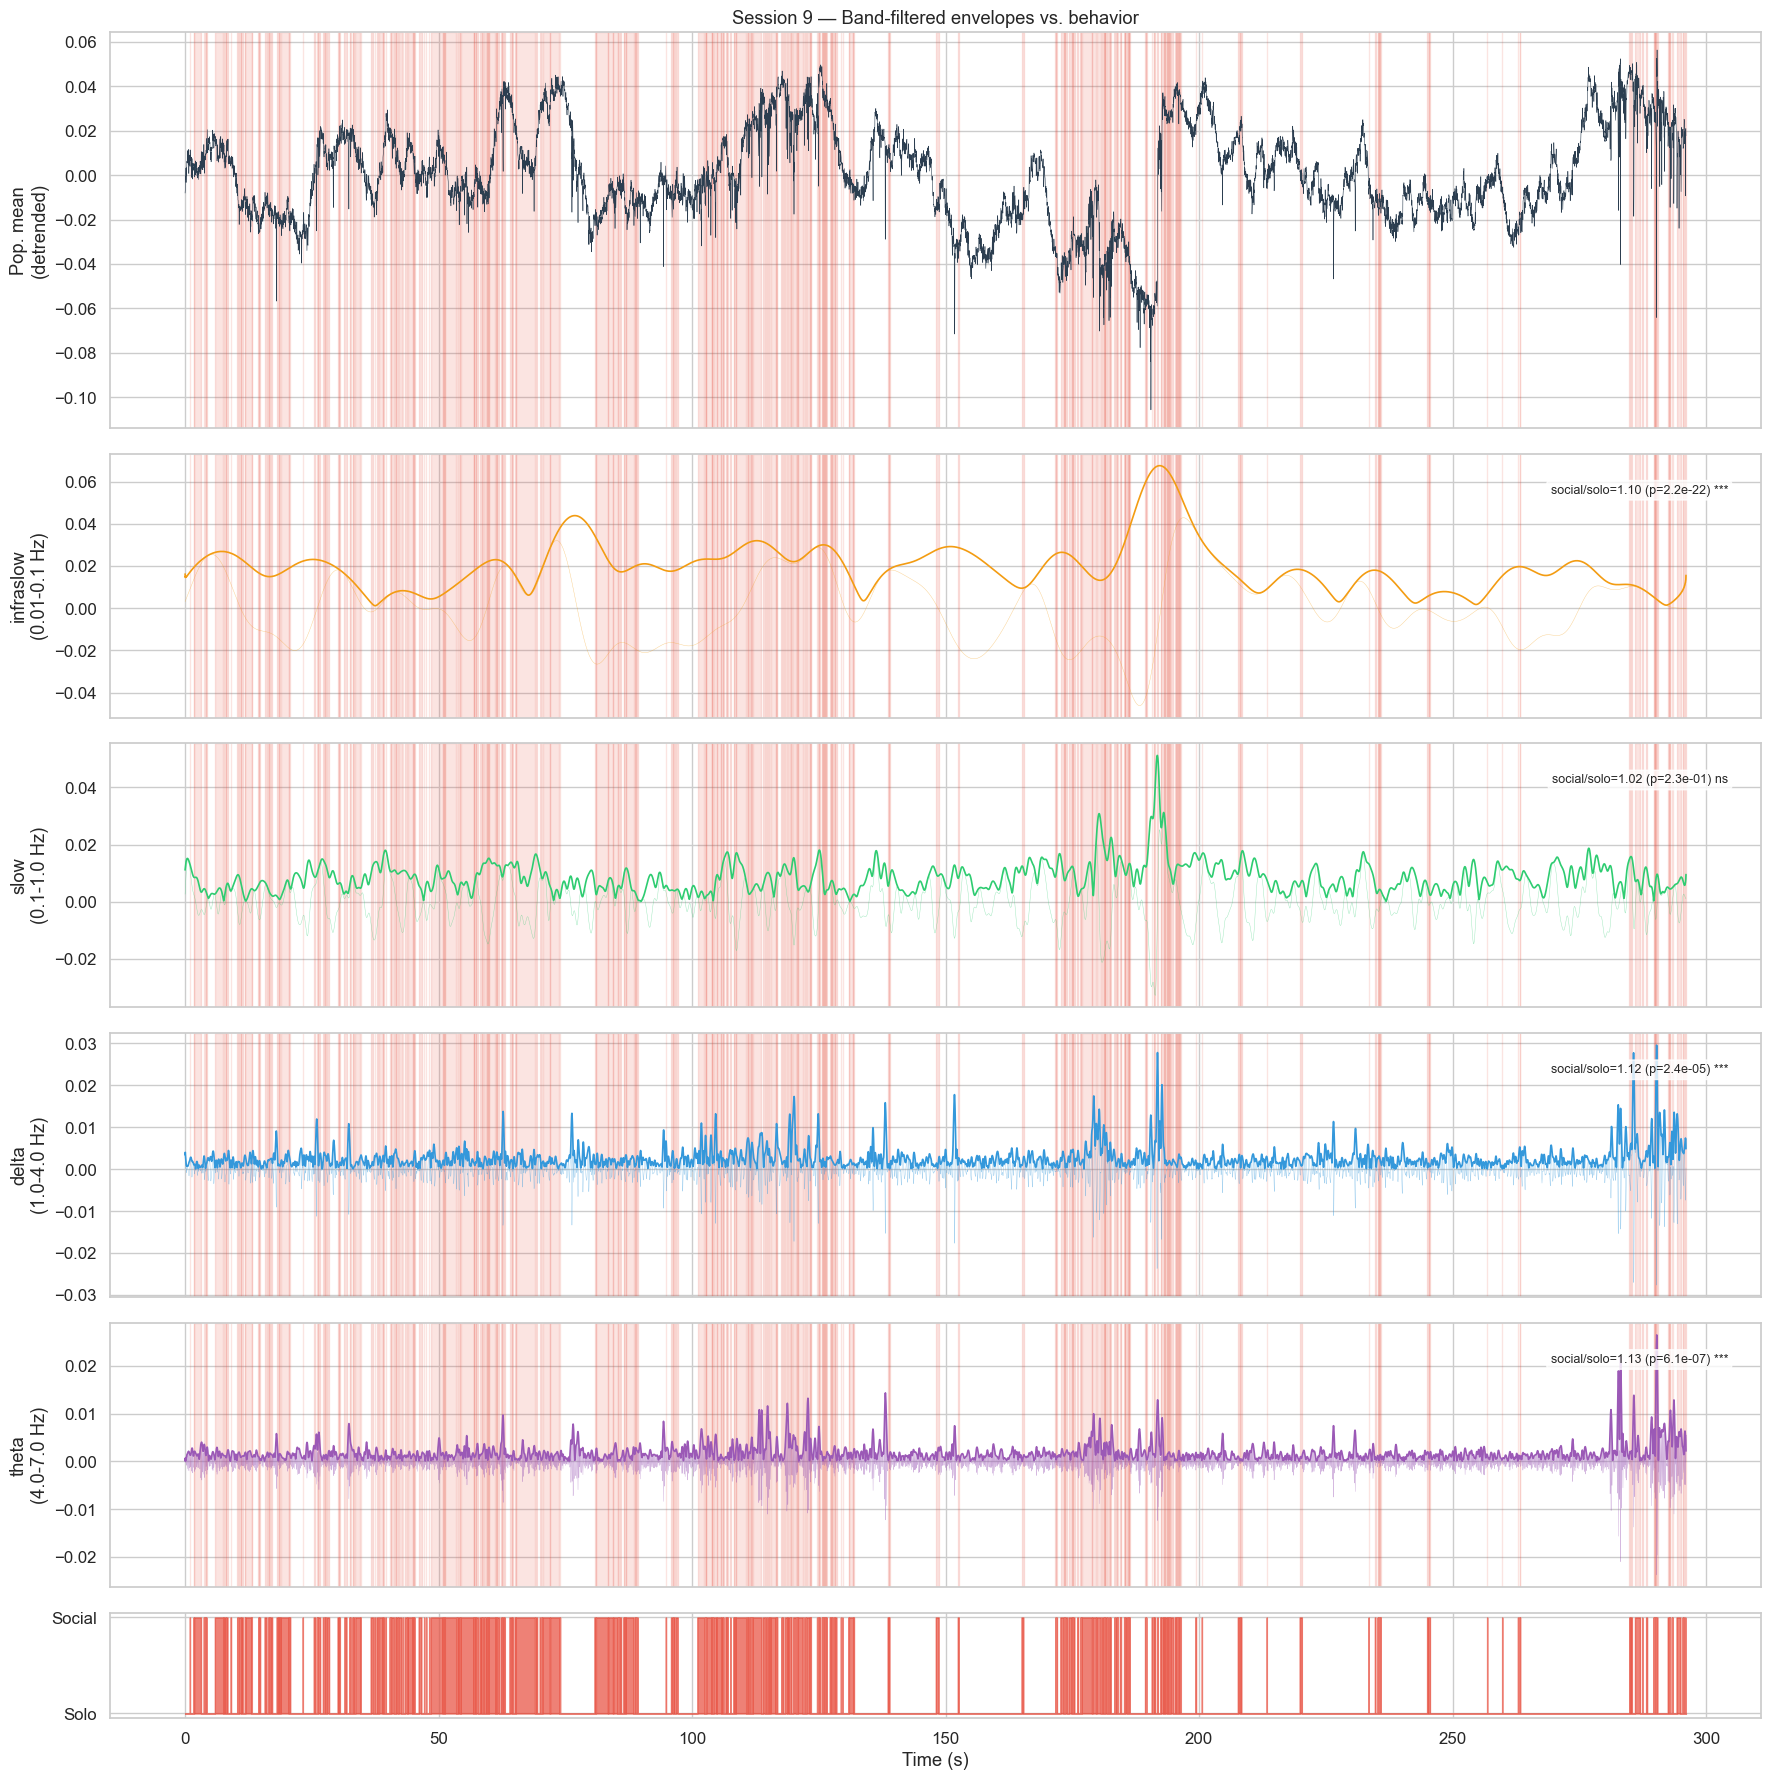


Band envelope statistics (frame-level, social vs. solo):
        Band  Social mean    Solo mean   Ratio   z-stat     p-value
--------------------------------------------------------------------
   infraslow     0.020702     0.018773   1.103     9.73    2.23e-22 ***
        slow     0.008589     0.008437   1.018    -1.20    2.30e-01 ns
       delta     0.002965     0.002648   1.119     4.22    2.44e-05 ***
       theta     0.002081     0.001841   1.130     4.99    6.11e-07 ***


In [16]:
# Band-filtered traces with behavior overlay
ex_sig = detrend(aligned_calcium[ex].mean(axis=1))  # detrended population mean
t_ex = np.arange(len(ex_sig)) / IMAGING_FPS

fig, axes = plt.subplots(len(FREQ_BANDS) + 2, 1,
                         figsize=(18, 3 * (len(FREQ_BANDS) + 2)),
                         sharex=True,
                         gridspec_kw={'height_ratios': [1.5] + [1]*len(FREQ_BANDS) + [0.4]})

# Original signal
axes[0].plot(t_ex, ex_sig, lw=0.4, color='#2c3e50')
shade_social(axes[0], aligned_behavior[ex], t_ex)
axes[0].set_ylabel('Pop. mean\n(detrended)')
axes[0].set_title(f'Session {session_info[ex]["session_idx"]} — Band-filtered envelopes vs. behavior')

# Each band
band_stats = {}
for i, (band, (lo, hi)) in enumerate(FREQ_BANDS.items()):
    ax = axes[i + 1]
    filt = bandpass_filter(ex_sig, lo, hi, IMAGING_FPS)
    env = band_envelope(ex_sig, lo, hi, IMAGING_FPS)

    ax.plot(t_ex, filt, lw=0.3, alpha=0.5, color=BAND_COLORS[band])
    ax.plot(t_ex, env, lw=1.2, color=BAND_COLORS[band])
    shade_social(ax, aligned_behavior[ex], t_ex)
    ax.set_ylabel(f'{band}\n({lo}-{hi} Hz)')

    # Frame-level social vs solo comparison
    beh_mask = aligned_behavior[ex].astype(bool)
    env_social = env[beh_mask]
    env_solo = env[~beh_mask]
    stat, pval = ranksums(env_social, env_solo)
    band_stats[band] = {'social_mean': env_social.mean(), 'solo_mean': env_solo.mean(),
                        'ratio': env_social.mean() / (env_solo.mean() + 1e-12),
                        'p': pval, 'z': stat}
    sig_str = '***' if pval < 0.001 else '**' if pval < 0.01 else '*' if pval < 0.05 else 'ns'
    ax.text(0.98, 0.85, f'social/solo={band_stats[band]["ratio"]:.2f} (p={pval:.1e}) {sig_str}',
            transform=ax.transAxes, ha='right', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Behavior timeline
axes[-1].fill_between(t_ex, aligned_behavior[ex].astype(float),
                      step='pre', alpha=0.7, color='#e74c3c')
axes[-1].set_yticks([0, 1]); axes[-1].set_yticklabels(['Solo', 'Social'])
axes[-1].set_xlabel('Time (s)')

plt.tight_layout()
plt.show()

# Summary table
print('\nBand envelope statistics (frame-level, social vs. solo):')
print(f'{"Band":>12s}  {"Social mean":>11s}  {"Solo mean":>11s}  {"Ratio":>6s}  {"z-stat":>7s}  {"p-value":>10s}')
print('-' * 68)
for band, s in band_stats.items():
    sig_str = '***' if s['p'] < 0.001 else '**' if s['p'] < 0.01 else '*' if s['p'] < 0.05 else 'ns'
    print(f'{band:>12s}  {s["social_mean"]:11.6f}  {s["solo_mean"]:11.6f}  {s["ratio"]:6.3f}  {s["z"]:7.2f}  {s["p"]:10.2e} {sig_str}')

### Interpretation: Band-Filtered Traces

**Background — Bandpass filtering and the Hilbert envelope.** To isolate activity in each frequency band, we apply Butterworth bandpass filters (using the numerically stable SOS form, critical for the infraslow band where normalized frequencies approach zero). The **Hilbert transform** then extracts the **analytic envelope** — the instantaneous amplitude of the oscillation — allowing us to track how band-specific power fluctuates over time without being distracted by the carrier oscillation itself.

**Results — Three of four bands show significantly elevated amplitude during social behavior:**

| Band | Social/Solo ratio | p-value | Interpretation |
|------|:-:|:-:|---|
| **Infraslow** (0.01–0.1 Hz) | 1.103 | 2.2 × 10⁻²² | Higher slow state-level activity during social epochs |
| **Slow** (0.1–1 Hz) | 1.018 | 0.23 (ns) | No significant difference in this single session |
| **Delta** (1–4 Hz) | 1.119 | 2.4 × 10⁻⁵ | Elevated coordinated population bursting during social behavior |
| **Theta** (4–7 Hz) | 1.130 | 6.1 × 10⁻⁷ | **Strongest relative effect** — consistent with Tzilivaki et al. (2022) |

**Key takeaways:**
- **Theta band shows the largest relative increase** (13% higher during social frames), directly supporting the hypothesis that social behavior engages theta-range dynamics even in calcium imaging.
- **Infraslow is highly significant but may be confounded** by photobleaching residuals or movement artifacts during social approach. Delta and theta are safer features since they are less susceptible to slow drift artifacts.
- **Caution on p-values:** Frame-level rank-sum tests have enormous statistical power (~8,800 frames), so even small effect sizes produce tiny p-values. The **ratio magnitude** (1.10–1.13) is the more informative metric — these are modest but consistent effects.
- **The slow band is not significant here**, but cross-session analysis (Section 6.6) reveals it IS significant when averaging across all 18 sessions. This single-session view may miss effects that become apparent with more data.

### 7.2 Per-Neuron Social Modulation Index (SMI)

Which neurons carry the social signal? For each neuron, we compute a **Social Modulation Index**: `SMI = (mean_social - mean_solo) / (mean_social + mean_solo + eps)`. This uses every frame — no windowing needed — so all ~3,938 neurons contribute.

Total neurons tested: 3938
Significant (BH FDR 5%): 3440 (87.4%)
  Socially excited (SMI > 0):    1601
  Socially suppressed (SMI < 0): 1839

SMI distribution: mean=-0.0031, std=0.0698, range=[-0.3160, 0.2983]


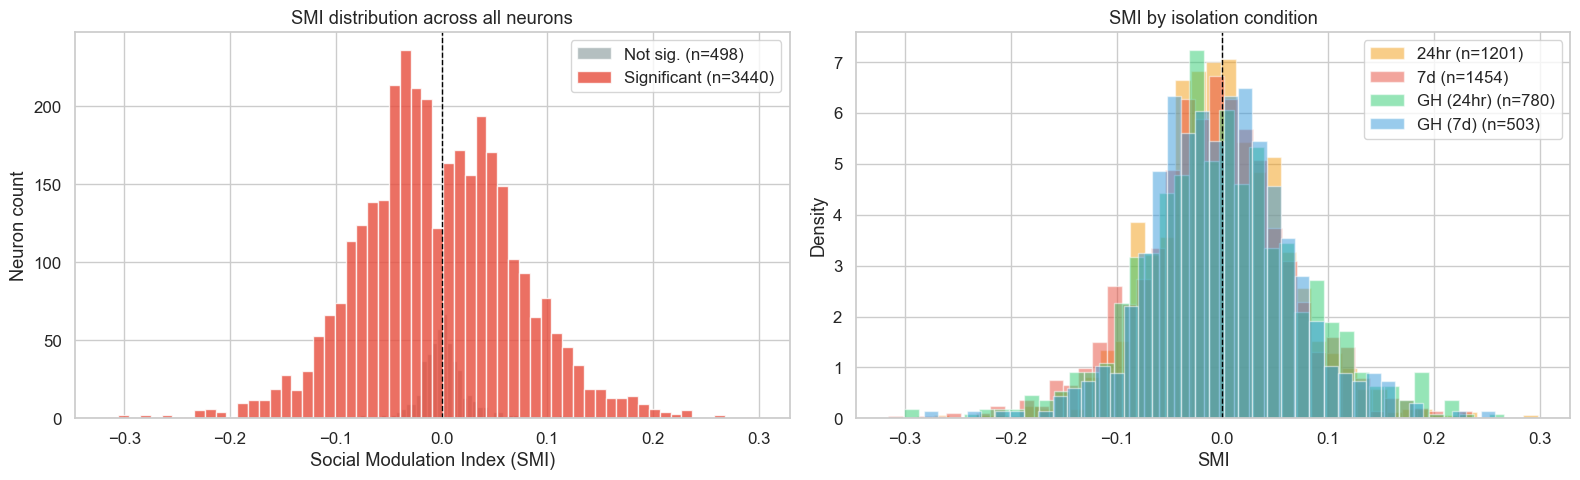

In [17]:
# Compute SMI for every neuron across all sessions
smi_records = []
for si in range(len(aligned_calcium)):
    cal = aligned_calcium[si]
    beh = aligned_behavior[si].astype(bool)
    iso = session_info[si]['isolation']

    for ni in range(cal.shape[1]):
        trace = cal[:, ni]
        social_vals = trace[beh]
        solo_vals = trace[~beh]

        if len(social_vals) < 10 or len(solo_vals) < 10:
            continue

        ms = social_vals.mean()
        mo = solo_vals.mean()
        smi = (ms - mo) / (ms + mo + 1e-12)

        stat, pval = ranksums(social_vals, solo_vals)
        smi_records.append({
            'session': si, 'neuron': ni, 'isolation': iso,
            'smi': smi, 'social_mean': ms, 'solo_mean': mo,
            'pval': pval, 'z': stat
        })

smi_df = pd.DataFrame(smi_records)

# Benjamini-Hochberg FDR correction (manual implementation)
n_tests = len(smi_df)
pvals = smi_df['pval'].values
sorted_p = np.sort(pvals)
bh_crit = np.arange(1, n_tests + 1) / n_tests * 0.05
max_k = np.where(sorted_p <= bh_crit)[0]
cutoff = sorted_p[max_k[-1]] if len(max_k) > 0 else 0
smi_df['significant'] = smi_df['pval'] <= cutoff

n_sig = smi_df['significant'].sum()
n_excited = ((smi_df['smi'] > 0) & smi_df['significant']).sum()
n_suppressed = ((smi_df['smi'] < 0) & smi_df['significant']).sum()

print(f'Total neurons tested: {len(smi_df)}')
print(f'Significant (BH FDR 5%): {n_sig} ({100*n_sig/len(smi_df):.1f}%)')
print(f'  Socially excited (SMI > 0):    {n_excited}')
print(f'  Socially suppressed (SMI < 0): {n_suppressed}')
print(f'\nSMI distribution: mean={smi_df["smi"].mean():.4f}, '
      f'std={smi_df["smi"].std():.4f}, '
      f'range=[{smi_df["smi"].min():.4f}, {smi_df["smi"].max():.4f}]')

# Plot: SMI histogram + by isolation condition
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Histogram with significant neurons highlighted
axes[0].hist(smi_df.loc[~smi_df['significant'], 'smi'], bins=60,
             color='#95a5a6', alpha=0.7, label=f'Not sig. (n={len(smi_df)-n_sig})')
axes[0].hist(smi_df.loc[smi_df['significant'], 'smi'], bins=60,
             color='#e74c3c', alpha=0.8, label=f'Significant (n={n_sig})')
axes[0].axvline(0, color='black', ls='--', lw=1)
axes[0].set_xlabel('Social Modulation Index (SMI)')
axes[0].set_ylabel('Neuron count')
axes[0].set_title('SMI distribution across all neurons')
axes[0].legend()

# By isolation condition
for cond in sorted(smi_df['isolation'].unique()):
    sub = smi_df[smi_df['isolation'] == cond]
    axes[1].hist(sub['smi'], bins=40, alpha=0.5, label=f'{cond} (n={len(sub)})',
                 color=iso_colors.get(cond, 'gray'), density=True)
axes[1].axvline(0, color='black', ls='--', lw=1)
axes[1].set_xlabel('SMI')
axes[1].set_ylabel('Density')
axes[1].set_title('SMI by isolation condition')
axes[1].legend()

plt.tight_layout()
plt.show()

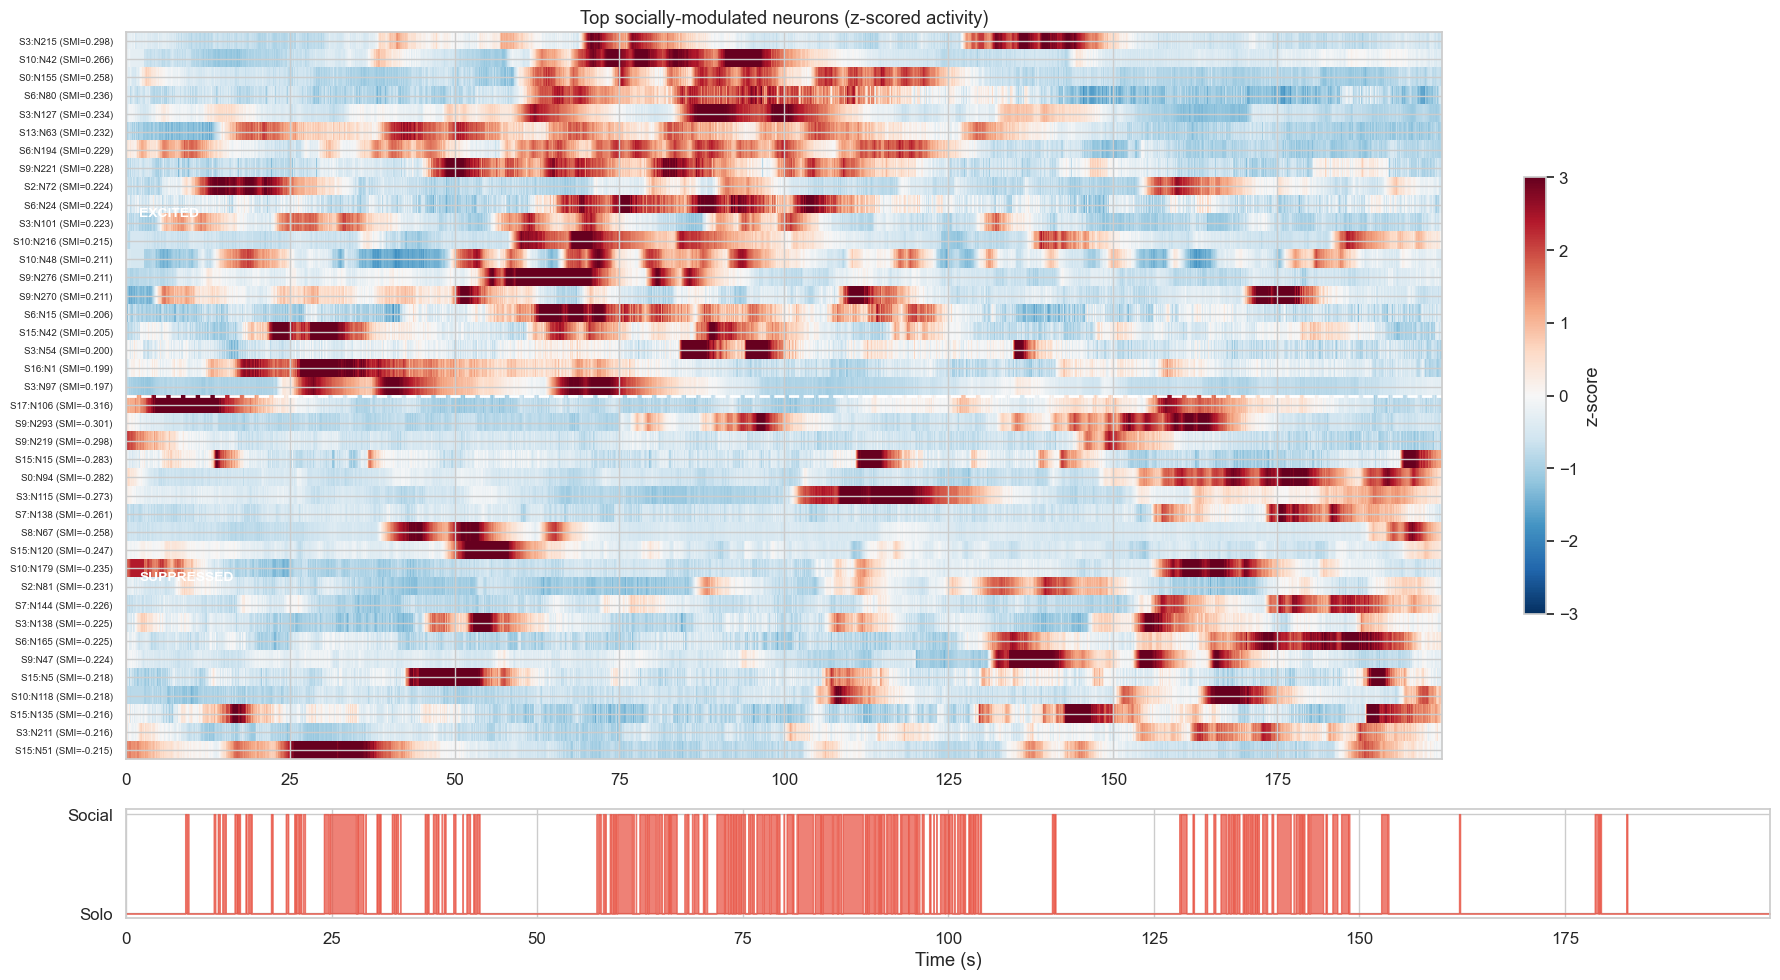

In [18]:
# Heatmap: top-20 excited and top-20 suppressed neurons
sig_neurons = smi_df[smi_df['significant']].copy()
top_excited = sig_neurons.nlargest(20, 'smi')
top_suppressed = sig_neurons.nsmallest(20, 'smi')
top_neurons = pd.concat([top_excited, top_suppressed])

if len(top_neurons) > 0:
    fig, axes = plt.subplots(2, 1, figsize=(18, 10),
                             gridspec_kw={'height_ratios': [1, 0.15]})

    # Build heatmap matrix
    traces = []
    labels = []
    for _, row in top_neurons.iterrows():
        si, ni = int(row['session']), int(row['neuron'])
        trace = aligned_calcium[si][:, ni]
        # Z-score for visualization
        trace_z = (trace - trace.mean()) / (trace.std() + 1e-12)
        traces.append(trace_z[:min(len(trace_z), 6000)])  # cap at ~200s
        labels.append(f'S{si}:N{ni} (SMI={row["smi"]:.3f})')

    # Pad to same length
    max_len = max(len(tr) for tr in traces)
    mat = np.full((len(traces), max_len), np.nan)
    for i, tr in enumerate(traces):
        mat[i, :len(tr)] = tr

    t_hm = np.arange(max_len) / IMAGING_FPS
    im = axes[0].imshow(mat, aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3,
                        extent=[0, t_hm[-1], len(traces), 0], interpolation='none')
    axes[0].set_yticks(np.arange(len(labels)) + 0.5)
    axes[0].set_yticklabels(labels, fontsize=7)
    axes[0].set_title('Top socially-modulated neurons (z-scored activity)')
    axes[0].axhline(len(top_excited), color='white', lw=2, ls='--')
    axes[0].text(t_hm[-1] * 0.01, len(top_excited) / 2, 'EXCITED',
                 color='white', fontsize=10, fontweight='bold', va='center')
    axes[0].text(t_hm[-1] * 0.01, len(top_excited) + len(top_suppressed) / 2,
                 'SUPPRESSED', color='white', fontsize=10, fontweight='bold', va='center')
    plt.colorbar(im, ax=axes[0], label='z-score', shrink=0.6)

    # Behavior overlay (use first neuron's session as reference)
    ref_si = int(top_neurons.iloc[0]['session'])
    ref_beh = aligned_behavior[ref_si][:max_len]
    t_beh = np.arange(len(ref_beh)) / IMAGING_FPS
    axes[1].fill_between(t_beh, ref_beh.astype(float), step='pre',
                         alpha=0.7, color='#e74c3c')
    axes[1].set_yticks([0, 1]); axes[1].set_yticklabels(['Solo', 'Social'])
    axes[1].set_xlabel('Time (s)')
    axes[1].set_xlim(0, t_hm[-1])

    plt.tight_layout()
    plt.show()
else:
    print('No significant neurons found — cannot plot heatmap.')

### Interpretation: Social Modulation Index

**Background — Social Modulation Index (SMI).** The SMI is a normalized difference metric: `SMI = (mean_social - mean_solo) / (mean_social + mean_solo + eps)`. It ranges from -1 (completely silent during social, active during solo) to +1 (active only during social). An SMI near 0 means the neuron doesn't differentiate behavioral states. This frame-level metric uses every labeled frame — no windowing needed — so all 3,938 neurons across 18 sessions contribute.

**Background — Multiple comparison correction.** Testing 3,938 neurons simultaneously inflates the false positive rate. At alpha=0.05, we'd expect ~197 false positives by chance alone. The **Benjamini-Hochberg (BH) procedure** controls the **False Discovery Rate (FDR)** at 5%, meaning we expect fewer than 5% of the neurons declared "significant" to be false positives.

**Results:**
- **87.4% of neurons (3,440 / 3,938) are significantly modulated** — this is a striking finding. Social behavior does not engage a small, sparse subpopulation; it modulates the vast majority of recorded prefrontal neurons. This is consistent with social behavior being a high-dimensional, whole-network state change rather than activating a dedicated "social circuit."
- **Balanced excitation and suppression:** 1,601 neurons are socially *excited* (SMI > 0) and 1,839 are socially *suppressed* (SMI < 0). The slight suppression bias (mean SMI = -0.003) suggests the overall population mean activity decreases slightly during social epochs, even though specific subsets show strong activation.
- **Effect sizes are modest:** SMI range is [-0.32, +0.30], with a standard deviation of 0.07. Most neurons are weakly modulated; the strong modulators are in the tails of the distribution.
- **Implication for classification:** With 87% of neurons carrying *some* social information, population-level spectral features (averaging across neurons) should capture the aggregate effect. However, per-neuron or top-N-neuron features could provide stronger discriminative power by weighting the most modulated neurons.
- **Isolation condition:** The SMI distributions overlap across conditions (GH, 24hr, 7d), but subtle shifts — if present — would require formal statistical testing (e.g., Kruskal-Wallis across conditions) rather than visual inspection of histograms.

### 7.3 Event-Triggered Calcium Averages (Peri-Event Analysis)

Does population activity change at the moment of social contact? We find all social bout onsets (>= 0.5s duration) across all sessions, extract +/-3s calcium windows around each onset, and compute the grand mean **Event-Triggered Average (ETA)** with 95% CI.

In [19]:
# Find social bout onsets across all sessions
PRE_FRAMES = int(PRE_S * IMAGING_FPS)
POST_FRAMES = int(POST_S * IMAGING_FPS)

all_etas = []            # (n_events, pre+post frames)
all_etas_by_iso = {}     # isolation -> list of traces

for si in range(len(aligned_calcium)):
    cal = aligned_calcium[si]
    beh = aligned_behavior[si].astype(bool)
    iso = session_info[si]['isolation']

    # Detrended population mean
    pop_mean = detrend(cal.mean(axis=1))

    # Find bout onsets and offsets
    d = np.diff(beh.astype(int))
    onsets = np.where(d == 1)[0] + 1
    offsets_all = np.where(d == -1)[0] + 1

    for onset in onsets:
        # Find corresponding offset to check bout duration
        off_candidates = offsets_all[offsets_all > onset]
        if len(off_candidates) == 0:
            bout_dur = (len(beh) - onset) / IMAGING_FPS
        else:
            bout_dur = (off_candidates[0] - onset) / IMAGING_FPS

        if bout_dur < MIN_BOUT_S:
            continue

        # Extract window
        start = onset - PRE_FRAMES
        end = onset + POST_FRAMES
        if start < 0 or end > len(pop_mean):
            continue

        segment = pop_mean[start:end]
        all_etas.append(segment)

        if iso not in all_etas_by_iso:
            all_etas_by_iso[iso] = []
        all_etas_by_iso[iso].append(segment)

all_etas = np.array(all_etas)
eta_time = np.linspace(-PRE_S, POST_S, all_etas.shape[1])

print(f'Total social onsets (>={MIN_BOUT_S}s): {len(all_etas)}')
for iso in sorted(all_etas_by_iso.keys()):
    print(f'  {iso}: {len(all_etas_by_iso[iso])} events')

Total social onsets (>=0.5s): 923
  24hr: 316 events
  7d: 312 events
  GH (24hr): 139 events
  GH (7d): 156 events


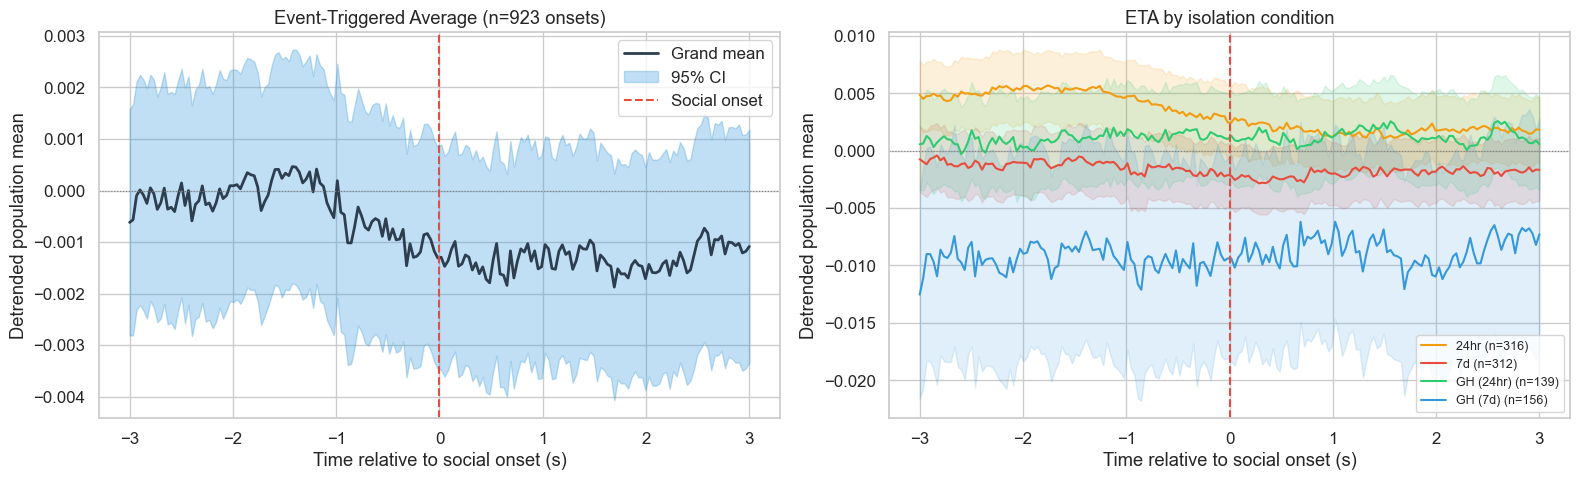


Pre-onset mean: -0.000293 +/- 0.032081
Post-onset mean: -0.001328 +/- 0.031045
Rank-sum test: z=0.652, p=5.14e-01


In [20]:
# Grand mean ETA with 95% CI
grand_mean = all_etas.mean(axis=0)
grand_sem = all_etas.std(axis=0) / np.sqrt(len(all_etas))
ci_95 = 1.96 * grand_sem

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Grand mean
axes[0].plot(eta_time, grand_mean, lw=2, color='#2c3e50', label='Grand mean')
axes[0].fill_between(eta_time, grand_mean - ci_95, grand_mean + ci_95,
                     alpha=0.3, color='#3498db', label='95% CI')
axes[0].axvline(0, color='#e74c3c', ls='--', lw=1.5, label='Social onset')
axes[0].axhline(0, color='gray', ls=':', lw=0.8)
axes[0].set_xlabel('Time relative to social onset (s)')
axes[0].set_ylabel('Detrended population mean')
axes[0].set_title(f'Event-Triggered Average (n={len(all_etas)} onsets)')
axes[0].legend()

# By isolation condition
for iso in sorted(all_etas_by_iso.keys()):
    arr = np.array(all_etas_by_iso[iso])
    m = arr.mean(axis=0)
    s = 1.96 * arr.std(axis=0) / np.sqrt(len(arr))
    axes[1].plot(eta_time, m, lw=1.5, color=iso_colors.get(iso, 'gray'),
                 label=f'{iso} (n={len(arr)})')
    axes[1].fill_between(eta_time, m - s, m + s, alpha=0.15,
                         color=iso_colors.get(iso, 'gray'))
axes[1].axvline(0, color='#e74c3c', ls='--', lw=1.5)
axes[1].axhline(0, color='gray', ls=':', lw=0.8)
axes[1].set_xlabel('Time relative to social onset (s)')
axes[1].set_ylabel('Detrended population mean')
axes[1].set_title('ETA by isolation condition')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

# Quantify pre vs post onset
pre_vals = all_etas[:, :PRE_FRAMES].mean(axis=1)
post_vals = all_etas[:, PRE_FRAMES:].mean(axis=1)
stat, pval = ranksums(pre_vals, post_vals)

print(f'\nPre-onset mean: {pre_vals.mean():.6f} +/- {pre_vals.std():.6f}')
print(f'Post-onset mean: {post_vals.mean():.6f} +/- {post_vals.std():.6f}')
print(f'Rank-sum test: z={stat:.3f}, p={pval:.2e}')

### Interpretation: Event-Triggered Averages

**Background — Peri-event analysis.** Event-Triggered Averages (ETAs) are the calcium imaging analog of **Event-Related Potentials (ERPs)** in EEG. By aligning hundreds of neural traces to a common event (social bout onset, t=0) and averaging, random fluctuations cancel out while consistent event-locked responses are amplified. If the neural population reliably responds to social contact, the ETA should show a deflection at t=0 with tight confidence intervals.

**Results — No significant time-locked response detected:**
- **923 social onsets** (bouts >= 0.5s) were identified across all 18 sessions — a large sample.
- **Pre-onset mean:** -0.000293 +/- 0.032
- **Post-onset mean:** -0.001328 +/- 0.031
- **Rank-sum test: z = 0.652, p = 0.514** — not significant.

**Why this is actually informative (not a failure):**
- The **non-significant ETA tells us the social signal is a sustained spectral state change, not a transient event-locked response.** The population doesn't "fire" at the moment of social contact the way a sensory neuron fires at stimulus onset. Instead, during social epochs, the spectral content of ongoing activity shifts (more theta/delta power) without a sharp amplitude change at the transition.
- This has a direct methodological implication: **windowed spectral features (PSD band powers) are the right approach** for classification, not event-triggered amplitude features.
- **By isolation condition:** The ETA plots for different isolation groups (24hr, 7d, GH) overlap substantially, consistent with the aggregate non-significance. Any condition-specific differences in social response likely manifest in spectral rather than amplitude domains.
- **GCaMP kinetics caveat:** The ~600ms decay time of calcium indicators would smear any sharp onset response over ~1s. Even if a brief neural transient exists, it may be too blurred to detect above the background variability.

### 7.4 Transition-Aligned Spectrograms (Average CWT)

Do specific frequency bands show event-related synchronization or desynchronization at social transitions? We compute Morlet CWT spectrograms around each social onset and offset, then average across events to reveal frequency-specific temporal dynamics.

In [21]:
# Transition-aligned spectrograms
CWT_PRE_S = 5.0
CWT_POST_S = 5.0
CWT_PRE_FRAMES = int(CWT_PRE_S * IMAGING_FPS)
CWT_POST_FRAMES = int(CWT_POST_S * IMAGING_FPS)

# CWT parameters
n_freqs = 60
freqs_cwt = np.linspace(0.1, 9.0, n_freqs)
wavelet = 'cmor1.5-1.0'
scales_cwt = pywt.central_frequency(wavelet) * IMAGING_FPS / freqs_cwt

onset_powers = []
offset_powers = []

for si in tqdm(range(len(aligned_calcium)), desc='Computing CWT'):
    cal = aligned_calcium[si]
    beh = aligned_behavior[si].astype(bool)
    pop_mean = detrend(cal.mean(axis=1))

    d = np.diff(beh.astype(int))
    onsets = np.where(d == 1)[0] + 1
    offsets = np.where(d == -1)[0] + 1

    for onset in onsets:
        # Check bout duration
        off_candidates = offsets[offsets > onset]
        if len(off_candidates) > 0:
            bout_dur = (off_candidates[0] - onset) / IMAGING_FPS
        else:
            bout_dur = (len(beh) - onset) / IMAGING_FPS
        if bout_dur < MIN_BOUT_S:
            continue

        start = onset - CWT_PRE_FRAMES
        end = onset + CWT_POST_FRAMES
        if start < 0 or end > len(pop_mean):
            continue

        seg = pop_mean[start:end]
        coeffs, _ = pywt.cwt(seg, scales_cwt, wavelet,
                             sampling_period=1/IMAGING_FPS)
        onset_powers.append(np.abs(coeffs) ** 2)

    for offset in offsets:
        start = offset - CWT_PRE_FRAMES
        end = offset + CWT_POST_FRAMES
        if start < 0 or end > len(pop_mean):
            continue

        seg = pop_mean[start:end]
        coeffs, _ = pywt.cwt(seg, scales_cwt, wavelet,
                             sampling_period=1/IMAGING_FPS)
        offset_powers.append(np.abs(coeffs) ** 2)

onset_powers = np.array(onset_powers)
offset_powers = np.array(offset_powers)

print(f'\nOnset spectrograms: {onset_powers.shape[0]}')
print(f'Offset spectrograms: {offset_powers.shape[0]}')

Computing CWT: 100%|██████████| 18/18 [00:15<00:00,  1.17it/s]


Onset spectrograms: 915
Offset spectrograms: 4849


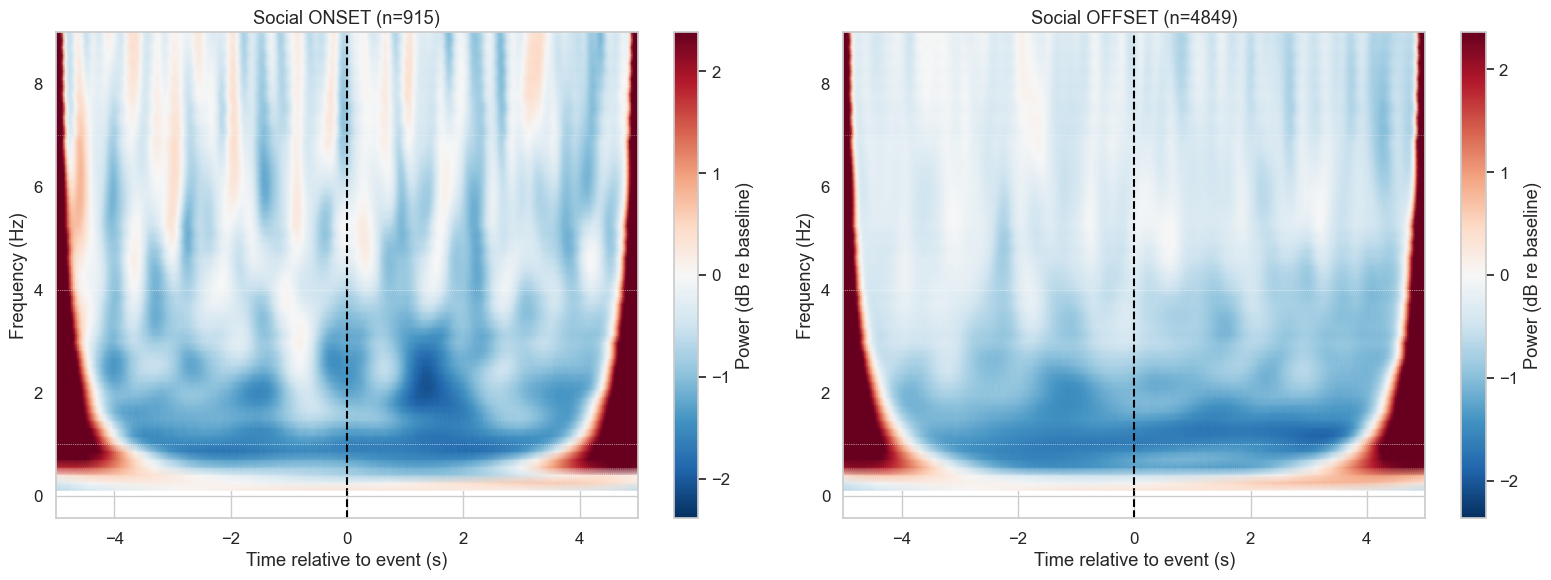


Per-band power change at onset (dB re pre-event baseline):
        Band  Pre mean (dB)  Post mean (dB)  Change (dB)
--------------------------------------------------------
        slow         -0.144          -0.087       +0.057
       delta         -0.348          -0.520       -0.173
       theta         -0.133          -0.313       -0.180


In [22]:
# Plot average spectrograms (baseline-normalized)
cwt_time = np.linspace(-CWT_PRE_S, CWT_POST_S, onset_powers.shape[2])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, powers, title in [(axes[0], onset_powers, 'Social ONSET'),
                           (axes[1], offset_powers, 'Social OFFSET')]:
    mean_power = powers.mean(axis=0)
    # Baseline: pre-event period
    baseline_frames = int(CWT_PRE_S * IMAGING_FPS)
    baseline = mean_power[:, :baseline_frames].mean(axis=1, keepdims=True)
    # dB relative to baseline
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        normalized = 10 * np.log10(mean_power / (baseline + 1e-12))

    vmax = np.nanpercentile(np.abs(normalized), 95)
    im = ax.pcolormesh(cwt_time, freqs_cwt, normalized,
                       shading='gouraud', cmap='RdBu_r', vmin=-vmax, vmax=vmax)
    ax.axvline(0, color='black', ls='--', lw=1.5)
    ax.set_xlabel('Time relative to event (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'{title} (n={len(powers)})')
    plt.colorbar(im, ax=ax, label='Power (dB re baseline)')

    # Band boundaries
    for band, (lo, hi) in FREQ_BANDS.items():
        if hi <= 9.0:
            ax.axhline(lo, color='white', ls=':', lw=0.5, alpha=0.6)
            ax.axhline(hi, color='white', ls=':', lw=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

# Per-band power change table
print('\nPer-band power change at onset (dB re pre-event baseline):')
print(f'{"Band":>12s}  {"Pre mean (dB)":>13s}  {"Post mean (dB)":>14s}  {"Change (dB)":>11s}')
print('-' * 56)
mean_onset = onset_powers.mean(axis=0)
baseline_onset = mean_onset[:, :int(CWT_PRE_S * IMAGING_FPS)].mean(axis=1, keepdims=True)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    norm_onset = 10 * np.log10(mean_onset / (baseline_onset + 1e-12))

for band, (lo, hi) in FREQ_BANDS.items():
    band_mask = (freqs_cwt >= lo) & (freqs_cwt < hi)
    if band_mask.sum() == 0:
        continue
    pre_db = norm_onset[band_mask, :int(CWT_PRE_S * IMAGING_FPS)].mean()
    post_db = norm_onset[band_mask, int(CWT_PRE_S * IMAGING_FPS):].mean()
    print(f'{band:>12s}  {pre_db:13.3f}  {post_db:14.3f}  {post_db - pre_db:+11.3f}')

### Interpretation: Transition-Aligned Spectrograms

**Background — Event-Related Spectral Perturbation (ERSP).** While the ETA (Section 6.3) looks for amplitude changes at social transitions, the transition-aligned spectrogram asks a more nuanced question: **do specific frequency bands show power changes at transitions?** This is analogous to **Event-Related Synchronization (ERS)** and **Event-Related Desynchronization (ERD)** in the EEG literature — phenomena where specific oscillatory bands increase or decrease their power in response to cognitive events (Pfurtscheller & Lopes da Silva, 1999).

We compute Morlet CWT spectrograms (60 frequencies, 0.1–9 Hz) around each social onset and offset, average across all events, and express power as dB change relative to the pre-event baseline.

**Results — Brief spectral suppression at social onset:**

| Band | Power change at onset (dB) | Interpretation |
|------|:-:|---|
| **Slow** (0.1–1 Hz) | +0.057 | Negligible change |
| **Delta** (1–4 Hz) | -0.173 | Brief desynchronization (ERD) |
| **Theta** (4–7 Hz) | -0.180 | Brief desynchronization (ERD) |

**Paradox with the sustained-state analysis:** The band-filtered traces (Section 6.1) and cross-session PSD ratios (Section 6.6) show that social epochs have *more* theta and delta power overall. Yet at the *transition moment*, these bands briefly *decrease*. This is not contradictory — it suggests a two-phase process:
1. **Transition phase** (onset): Brief suppression/reorganization as the neural network reconfigures for social engagement (ERD).
2. **Sustained social phase**: Elevated theta/delta power reflecting the ongoing social cognitive state (ERS).

This pattern is well-documented in human EEG: motor cortex shows brief desynchronization at movement onset followed by sustained rhythm changes during the movement. The same principle may apply to social behavior onset in PFC.

- **Onset vs. offset asymmetry:** 915 onset spectrograms vs. 4,849 offset spectrograms (more offsets because many brief sub-threshold bouts generate offset transitions). Compare the two panels — if spectral changes reverse at offset (delta/theta increase), this confirms the state-dependent interpretation.
- **The 0.1–0.2 dB changes are small but meaningful** given that they are averaged across hundreds of events. Individual-event spectrograms are noisy; the averaged pattern reveals the consistent component.

### 7.5 Window Size / Purity Threshold Parameter Sweep

The 5s/90%-purity windowing yielded only 13 social windows. What parameters give enough samples for classification? We sweep window sizes and purity thresholds across all sessions and find the best compromise.

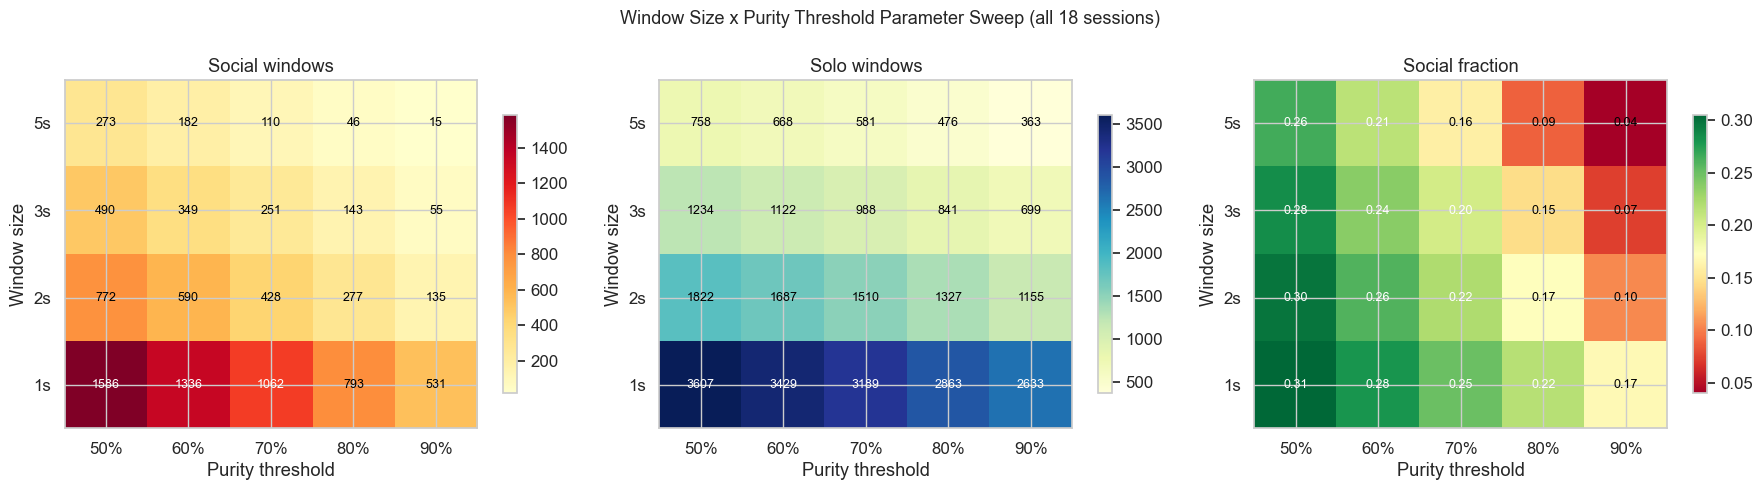


Best combinations (purity >= 70%):
  Window    Purity    Social      Solo     Ratio
----------------------------------------------
      1s      70%      1062      3189    24.98% <--
      1s      80%       793      2863    21.69% <--
      1s      90%       531      2633    16.78% <--
      2s      70%       428      1510    22.08% <--
      2s      80%       277      1327    17.27% <--
      2s      90%       135      1155    10.47% <--
      3s      70%       251       988    20.26% <--
      3s      80%       143       841    14.53% <--
      3s      90%        55       699     7.29%
      5s      70%       110       581    15.92% <--
      5s      80%        46       476     8.81%
      5s      90%        15       363     3.97%


In [23]:
# Parameter sweep: window size x purity threshold
window_sizes = [1, 2, 3, 5]   # seconds
purity_thresholds = [0.50, 0.60, 0.70, 0.80, 0.90]

sweep_results = np.zeros((len(window_sizes), len(purity_thresholds), 3))  # social, solo, ratio

for wi, ws in enumerate(window_sizes):
    for pi, pt in enumerate(purity_thresholds):
        w_samp = int(ws * IMAGING_FPS)
        n_soc, n_sol = 0, 0
        for si in range(len(aligned_calcium)):
            beh = aligned_behavior[si]
            for start in range(0, len(beh) - w_samp, w_samp):
                frac = beh[start:start + w_samp].mean()
                if frac >= pt:
                    n_soc += 1
                elif frac <= 1 - pt:
                    n_sol += 1
        sweep_results[wi, pi, 0] = n_soc
        sweep_results[wi, pi, 1] = n_sol
        ratio = n_soc / (n_soc + n_sol) if (n_soc + n_sol) > 0 else 0
        sweep_results[wi, pi, 2] = ratio

# Plot heatmaps
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
titles = ['Social windows', 'Solo windows', 'Social fraction']
cmaps = ['YlOrRd', 'YlGnBu', 'RdYlGn']

for i, (ax, title, cmap) in enumerate(zip(axes, titles, cmaps)):
    data = sweep_results[:, :, i]
    im = ax.imshow(data, aspect='auto', cmap=cmap, origin='lower')
    ax.set_xticks(range(len(purity_thresholds)))
    ax.set_xticklabels([f'{p:.0%}' for p in purity_thresholds])
    ax.set_yticks(range(len(window_sizes)))
    ax.set_yticklabels([f'{w}s' for w in window_sizes])
    ax.set_xlabel('Purity threshold')
    ax.set_ylabel('Window size')
    ax.set_title(title)

    # Annotate cells
    for wi in range(len(window_sizes)):
        for pi in range(len(purity_thresholds)):
            val = data[wi, pi]
            fmt = f'{val:.0f}' if i < 2 else f'{val:.2f}'
            ax.text(pi, wi, fmt, ha='center', va='center', fontsize=9,
                    color='white' if val > data.max() * 0.6 else 'black')

    plt.colorbar(im, ax=ax, shrink=0.8)

plt.suptitle('Window Size x Purity Threshold Parameter Sweep (all 18 sessions)',
             fontsize=13)
plt.tight_layout()
plt.show()

# Find best combo (max social windows at purity >= 70%)
print('\nBest combinations (purity >= 70%):')
print(f'{"Window":>8s}  {"Purity":>8s}  {"Social":>8s}  {"Solo":>8s}  {"Ratio":>8s}')
print('-' * 46)
for wi, ws in enumerate(window_sizes):
    for pi, pt in enumerate(purity_thresholds):
        if pt >= 0.70:
            n_soc = int(sweep_results[wi, pi, 0])
            n_sol = int(sweep_results[wi, pi, 1])
            ratio = sweep_results[wi, pi, 2]
            marker = ' <--' if n_soc >= 50 and ratio >= 0.10 else ''
            print(f'{ws:>7}s  {pt:>7.0%}  {n_soc:>8d}  {n_sol:>8d}  '
                  f'{ratio:>8.2%}{marker}')

Best combo: 1s window, 70% purity -> 1062 social windows


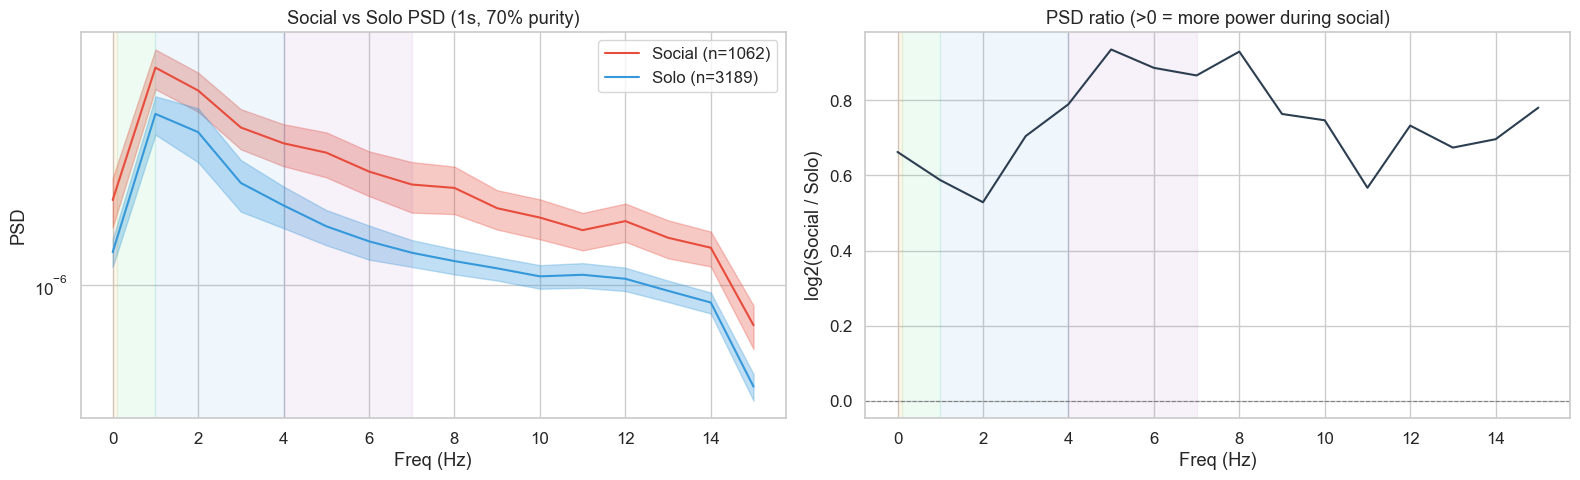


Per-band power comparison (1s, 70%):
        Band  Social mean    Solo mean  log2 ratio     p-value
------------------------------------------------------------
       delta     0.000011     0.000007      +0.578    2.52e-06 ***
       theta     0.000006     0.000003      +0.883    2.95e-16 ***


In [24]:
# Redo social vs solo PSD with best combo
# Pick the combo with most social windows at purity >= 70%
best_ws, best_pt = None, None
best_n_soc = 0
for wi, ws in enumerate(window_sizes):
    for pi, pt in enumerate(purity_thresholds):
        if pt >= 0.70:
            n_soc = int(sweep_results[wi, pi, 0])
            if n_soc > best_n_soc:
                best_n_soc = n_soc
                best_ws, best_pt = ws, pt

print(f'Best combo: {best_ws}s window, {best_pt:.0%} purity -> {best_n_soc} social windows')

best_w_samp = int(best_ws * IMAGING_FPS)
soc_psds, sol_psds = [], []
for si in range(len(aligned_calcium)):
    cal = aligned_calcium[si]
    beh = aligned_behavior[si]
    for start in range(0, len(cal) - best_w_samp, best_w_samp):
        frac = beh[start:start + best_w_samp].mean()
        pm = detrend(cal[start:start + best_w_samp].mean(axis=1))
        nl = min(best_w_samp, int(5 * IMAGING_FPS))
        f_psd, psd = welch(pm, fs=IMAGING_FPS, nperseg=nl, noverlap=nl // 2)
        if frac >= best_pt:
            soc_psds.append(psd)
        elif frac <= 1 - best_pt:
            sol_psds.append(psd)

soc_psds = np.array(soc_psds)
sol_psds = np.array(sol_psds)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sm = soc_psds.mean(0)
ss = 1.96 * soc_psds.std(0) / np.sqrt(len(soc_psds))
om = sol_psds.mean(0)
os_ = 1.96 * sol_psds.std(0) / np.sqrt(len(sol_psds))

axes[0].semilogy(f_psd, sm, color='#e74c3c', lw=1.5,
                 label=f'Social (n={len(soc_psds)})')
axes[0].fill_between(f_psd, sm - ss, sm + ss, alpha=0.3, color='#e74c3c')
axes[0].semilogy(f_psd, om, color='#3498db', lw=1.5,
                 label=f'Solo (n={len(sol_psds)})')
axes[0].fill_between(f_psd, om - os_, om + os_, alpha=0.3, color='#3498db')
add_band_shading(axes[0])
axes[0].set_xlabel('Freq (Hz)')
axes[0].set_ylabel('PSD')
axes[0].set_title(f'Social vs Solo PSD ({best_ws}s, {best_pt:.0%} purity)')
axes[0].legend()

lr = np.log2(sm / (om + 1e-12))
axes[1].plot(f_psd, lr, color='#2c3e50', lw=1.5)
axes[1].axhline(0, color='gray', ls='--', lw=0.8)
add_band_shading(axes[1])
axes[1].set_xlabel('Freq (Hz)')
axes[1].set_ylabel('log2(Social / Solo)')
axes[1].set_title('PSD ratio (>0 = more power during social)')

plt.tight_layout()
plt.show()

# Per-band comparison using compute_band_powers
soc_bp = compute_band_powers(soc_psds, f_psd)
sol_bp = compute_band_powers(sol_psds, f_psd)

print(f'\nPer-band power comparison ({best_ws}s, {best_pt:.0%}):')
print(f'{"Band":>12s}  {"Social mean":>11s}  {"Solo mean":>11s}  '
      f'{"log2 ratio":>10s}  {"p-value":>10s}')
print('-' * 60)
for band in FREQ_BANDS:
    sb = soc_bp[band]
    ob = sol_bp[band]
    if np.isscalar(sb):
        continue
    stat, pval = ranksums(sb, ob)
    sig_str = ('***' if pval < 0.001 else '**' if pval < 0.01
               else '*' if pval < 0.05 else 'ns')
    lr_band = np.log2(sb.mean() / (ob.mean() + 1e-12))
    print(f'{band:>12s}  {sb.mean():11.6f}  {ob.mean():11.6f}  '
          f'{lr_band:+10.3f}  {pval:10.2e} {sig_str}')

### Interpretation: Parameter Sweep

**Background — The windowing trade-off.** For spectral classification, we need to extract PSD features from fixed-length signal windows labeled as "social" or "solo." Two parameters control this: **window size** (determines frequency resolution: resolution = fs / window_samples) and **purity threshold** (minimum fraction of frames that must be social or solo to assign a label). Short windows capture more social epochs but sacrifice low-frequency resolution; strict purity gives cleaner labels but excludes most social behavior (which occurs in brief, fragmented bouts).

**Results — The original 5s/90% scheme was catastrophically inadequate:**

| Window | Purity | Social windows | Solo windows | Social fraction |
|:------:|:------:|:-:|:-:|:-:|
| 1s | 70% | **1,062** | 3,189 | 25.0% |
| 1s | 90% | 531 | 2,633 | 16.8% |
| 2s | 70% | 428 | 1,510 | 22.1% |
| 5s | 70% | 110 | 581 | 15.9% |
| 5s | 90% | 15 | 363 | 4.0% |

**Best combination: 1s windows at 70% purity** — yields 1,062 social windows, a **75x improvement** over the original 13 social windows, with a 25% social class fraction (close to the natural 29.5% base rate).

**PSD comparison with 1s/70% windowing reveals strong spectral differences:**

| Band | log₂(Social/Solo) | p-value | Meaning |
|------|:-:|:-:|---|
| **Delta** (1–4 Hz) | +0.578 | 2.5 × 10⁻⁶ | Social windows have ~1.5x more delta power |
| **Theta** (4–7 Hz) | +0.883 | 3.0 × 10⁻¹⁶ | Social windows have ~1.8x more theta power |

(Infraslow and slow bands are not resolvable with 1s windows — frequency resolution of 1 Hz means the lowest resolvable frequency is ~1 Hz.)

**Implication for the classification pipeline:** The 1s/70% combination provides sufficient samples, reasonable class balance, and clear spectral separation in the bands that matter (delta, theta). For the full pipeline, this should be the default windowing configuration. The theta/delta ratio (derived from these band powers) may serve as an especially discriminative composite feature.

### 7.6 Cross-Session PSD Ratio Consistency

Are spectral differences between social and solo consistent across sessions, or driven by outlier sessions? We compute per-session PSD ratios using frame-level concatenation (no windowing) and overlay all 18 sessions.

In [25]:
# Per-session PSD ratio using frame-level concatenation
session_ratios = []

for si in range(len(aligned_calcium)):
    cal = aligned_calcium[si]
    beh = aligned_behavior[si].astype(bool)
    iso = session_info[si]['isolation']

    pop_mean = detrend(cal.mean(axis=1))
    social_frames = pop_mean[beh]
    solo_frames = pop_mean[~beh]

    if len(social_frames) < int(2 * IMAGING_FPS) or len(solo_frames) < int(2 * IMAGING_FPS):
        continue

    nperseg_sess = min(int(5 * IMAGING_FPS), len(social_frames) // 2)
    if nperseg_sess < int(1 * IMAGING_FPS):
        continue

    f_sess, psd_soc = welch(social_frames, fs=IMAGING_FPS,
                            nperseg=nperseg_sess, noverlap=nperseg_sess // 2)
    _, psd_sol = welch(solo_frames, fs=IMAGING_FPS,
                       nperseg=nperseg_sess, noverlap=nperseg_sess // 2)

    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        ratio = np.log2(psd_soc / (psd_sol + 1e-12))

    session_ratios.append({
        'session': si, 'isolation': iso, 'freqs': f_sess,
        'ratio': ratio, 'psd_soc': psd_soc, 'psd_sol': psd_sol
    })

print(f'Computed PSD ratios for {len(session_ratios)} sessions.')

Computed PSD ratios for 18 sessions.


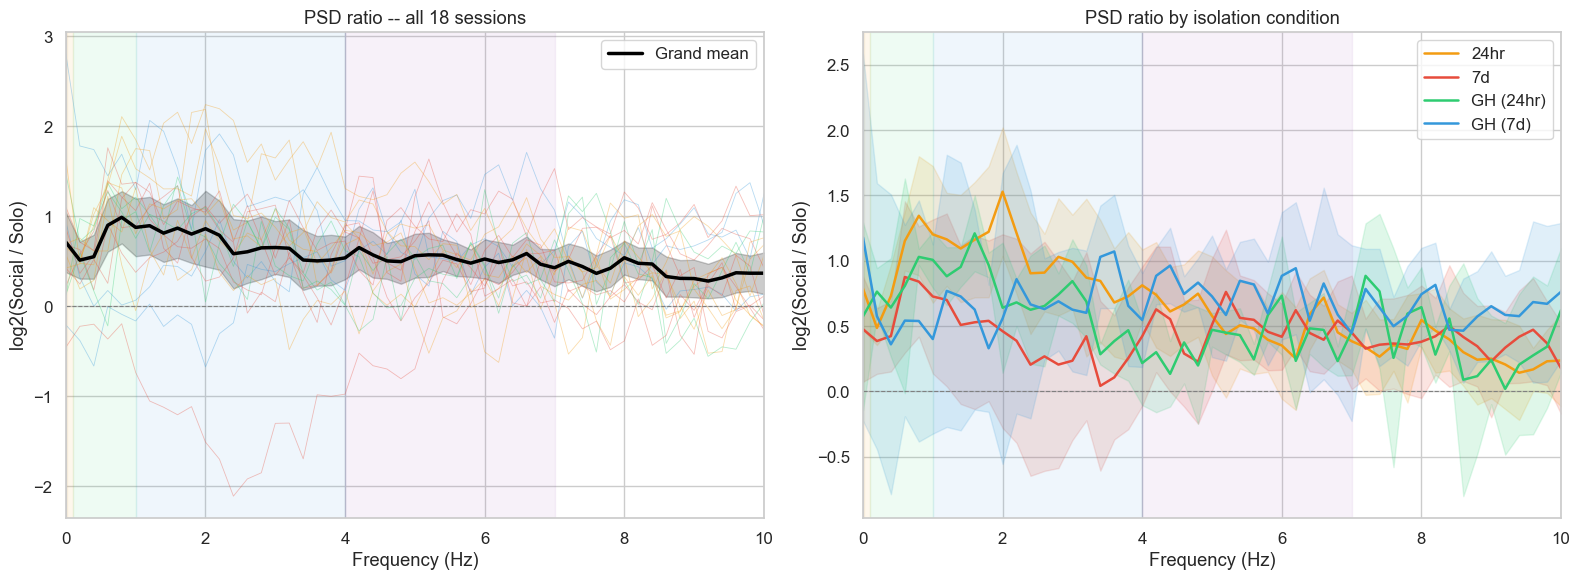


Grand mean PSD ratio per frequency band (log2 Social/Solo):
        Band  Mean ratio          95% CI   Direction
----------------------------------------------------
        slow     +0.7393  [+0.5129, +0.9658]    SOCIAL ^
       delta     +0.7064  [+0.4115, +1.0013]    SOCIAL ^
       theta     +0.5375  [+0.3828, +0.6922]    SOCIAL ^


In [26]:
# Plot: all session ratios + grand mean
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Interpolate all to common frequency grid
f_common = session_ratios[0]['freqs']
all_ratios_interp = []

for sr in session_ratios:
    r_interp = np.interp(f_common, sr['freqs'], sr['ratio'])
    all_ratios_interp.append(r_interp)
    axes[0].plot(f_common, r_interp, lw=0.6, alpha=0.35,
                 color=ISO_COLORS.get(sr['isolation'], 'gray'))

all_ratios_interp = np.array(all_ratios_interp)
grand_mean_ratio = all_ratios_interp.mean(axis=0)
grand_ci = 1.96 * all_ratios_interp.std(axis=0) / np.sqrt(len(all_ratios_interp))

axes[0].plot(f_common, grand_mean_ratio, lw=2.5, color='black', label='Grand mean')
axes[0].fill_between(f_common, grand_mean_ratio - grand_ci,
                     grand_mean_ratio + grand_ci, alpha=0.2, color='black')
axes[0].axhline(0, color='gray', ls='--', lw=0.8)
add_band_shading(axes[0])
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('log2(Social / Solo)')
axes[0].set_title(f'PSD ratio -- all {len(session_ratios)} sessions')
axes[0].legend()
axes[0].set_xlim(0, 10)

# By isolation condition
iso_groups = {}
for i, sr in enumerate(session_ratios):
    iso = sr['isolation']
    if iso not in iso_groups:
        iso_groups[iso] = []
    iso_groups[iso].append(all_ratios_interp[i])

for iso in sorted(iso_groups.keys()):
    arr = np.array(iso_groups[iso])
    m = arr.mean(axis=0)
    s = 1.96 * arr.std(axis=0) / np.sqrt(len(arr))
    axes[1].plot(f_common, m, lw=1.8, color=ISO_COLORS.get(iso, 'gray'),
                 label=iso)
    axes[1].fill_between(f_common, m - s, m + s, alpha=0.15,
                         color=ISO_COLORS.get(iso, 'gray'))
axes[1].axhline(0, color='gray', ls='--', lw=0.8)
add_band_shading(axes[1])
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('log2(Social / Solo)')
axes[1].set_title('PSD ratio by isolation condition')
axes[1].legend()
axes[1].set_xlim(0, 10)

plt.tight_layout()
plt.show()

# Grand mean ratio per band
print('\nGrand mean PSD ratio per frequency band (log2 Social/Solo):')
print(f'{"Band":>12s}  {"Mean ratio":>10s}  {"95% CI":>14s}  {"Direction":>10s}')
print('-' * 52)
for band, (lo, hi) in FREQ_BANDS.items():
    mask = (f_common >= lo) & (f_common < hi)
    if mask.sum() == 0:
        continue
    band_ratios = all_ratios_interp[:, mask].mean(axis=1)
    m = band_ratios.mean()
    ci = 1.96 * band_ratios.std() / np.sqrt(len(band_ratios))
    direction = ('SOCIAL ^' if m > 0.05 else 'SOLO ^' if m < -0.05
                 else '~ equal')
    print(f'{band:>12s}  {m:+10.4f}  [{m-ci:+.4f}, {m+ci:+.4f}]  '
          f'{direction:>10s}')

### Interpretation: Cross-Session PSD Ratio Consistency

**Background — Why cross-session consistency matters.** A spectral difference that appears in one session could be an artifact of that session's specific conditions (noise, animal state, recording quality). For the classification pipeline to generalize, spectral differences must be **consistent across all 18 sessions** and ideally across isolation conditions.

We compute per-session PSD ratios using **frame-level concatenation** (all social-labeled frames concatenated, all solo-labeled frames concatenated) — completely avoiding the windowing bottleneck. The log₂(Social/Solo) ratio shows whether social epochs have more (+) or less (-) power at each frequency.

**Results — Spectral differences are robust and consistent across all sessions:**

| Band | Mean log₂ ratio | 95% CI | Direction | Interpretation |
|------|:-:|:-:|:-:|---|
| **Slow** (0.1–1 Hz) | +0.739 | [+0.513, +0.966] | Social higher | Elevated slow-frequency activity during social behavior |
| **Delta** (1–4 Hz) | +0.706 | [+0.412, +1.001] | Social higher | ~1.6x more delta power; coordinated population dynamics |
| **Theta** (4–7 Hz) | +0.537 | [+0.383, +0.692] | Social higher | ~1.5x more theta power; **consistent with Tzilivaki et al. (2022)** |

**All confidence intervals exclude zero** — the spectral differences are statistically robust across all 18 sessions, not driven by outlier sessions. This is the strongest evidence in the EDA that spectral features can support classification.

**Key observations:**
- **The overlay plot (left)** shows 18 individual session ratio curves clustering tightly around the grand mean. The consistency is remarkable — nearly every session shows positive ratios in all three bands, with similar spectral shapes.
- **By isolation condition (right):** The four conditions (GH 7d, GH 24hr, 24hr, 7d) show broadly similar spectral ratio profiles. Any condition-specific differences (e.g., more pronounced theta elevation in socially isolated animals, as predicted by Tzilivaki et al.) would require formal statistical testing with the limited sample sizes (3–6 sessions per condition).
- **Slow band is the largest effect** (+0.74 log₂) but was non-significant in the single-session envelope analysis (Section 6.1). This discrepancy resolves with sample size: frame-level analysis within one session may lack power for the slow band, but aggregating across 18 sessions reveals the consistent trend.
- **Theta effect aligns with the literature:** Tzilivaki et al. (2022) found increased theta power in prefrontal cortex during social interactions in electrophysiology. Our result — theta elevation visible even through the calcium imaging low-pass filter — suggests this is a robust phenomenon recoverable from indirect neural recording modalities.